# Imports

In [4]:
import sys
sys.path.append('../src/')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import joblib
from sklearn.metrics import pairwise_distances
from PIL import Image
from sklearn.metrics import pairwise_distances
from sklearn.cluster import Birch
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.model_selection import train_test_split
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense
# import tensorflow as tf

from DataSetFactory import DataSetFactory
from ClusterPlot import ClusterPlot

In [5]:
RANDOM_STATE = 42

In [6]:
ds_scaled = DataSetFactory.get_dataset('wine-sklearn-scaled', random_state=RANDOM_STATE)
ds_not_scaled = DataSetFactory.get_dataset('wine-sklearn-not-scaled', random_state=RANDOM_STATE)

using min max scaler
skip scaling


In [7]:
X_scaled = ds_scaled.df[ds_scaled.feature_cols].values
y_scaled = ds_scaled.df[ds_scaled.label_col].values

X_not_scaled = ds_not_scaled.df[ds_not_scaled.feature_cols].values
y_not_scaled = ds_not_scaled.df[ds_not_scaled.label_col].values

In [8]:
X_scaled.shape
X_not_scaled.shape

(178, 13)

In [9]:
pd.Series(y_scaled).value_counts().sort_index()

0    59
1    71
2    48
dtype: int64

# Birch Threshold

In [10]:
def get_num_clusters_birch(ds, threshold):
    num_clusters = 0
    for label in ds.df[ds.label_col].unique():
        label_data = ds.df[ds.df[ds.label_col]==label][ds.feature_cols].values
        birch = Birch(threshold=threshold, branching_factor=2, n_clusters=None)
        birch.fit(label_data)
        num_clusters += birch.subcluster_centers_.shape[0]
    return num_clusters

def birch_threshold_plot(X, scaled, ds):
    dist_mat = pairwise_distances(X)
    print(dist_mat.shape)
    threshold_candidates = np.unique(dist_mat)
    print(threshold_candidates.shape)
    # for the sake of the experiment let's evaluate all of them
    thresholds_df = pd.DataFrame(threshold_candidates, columns=['threshold'])
    thresholds_df['num_clusters'] = np.nan
    thresholds_df['num_points'] = ds.df.shape[0]
    thresholds_df.hist(['threshold'])
    plt.show()
    # Filter only thresholds smaller than 1.5
    if scaled:
        thresholds_df_sample = thresholds_df[thresholds_df['threshold']<=100]
        thresholds_df_sample = thresholds_df_sample.sample(n=200, random_state=RANDOM_STATE)
    else:
        thresholds_df_sample = thresholds_df.sample(n=200)
    
    thresholds_df_sample['num_clusters'] = thresholds_df_sample['threshold'].transform(lambda t: get_num_clusters_birch(ds, t))
    thresholds_df_sample['compression'] = thresholds_df_sample['num_points'] / thresholds_df_sample['num_clusters']
    
    sns.lineplot(x='threshold', y='compression', data=thresholds_df_sample)
    sns.lineplot(x='threshold', y='num_clusters', data=thresholds_df_sample)

(178, 178)
(16313,)


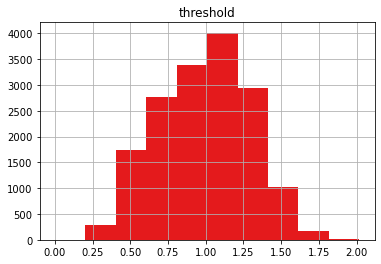

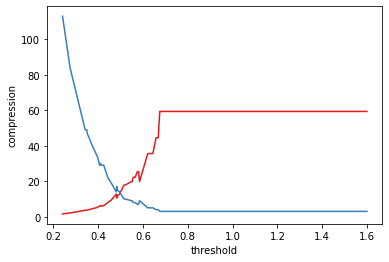

In [11]:
birch_threshold_plot(X_scaled, True, ds_scaled)

(178, 178)
(20397,)


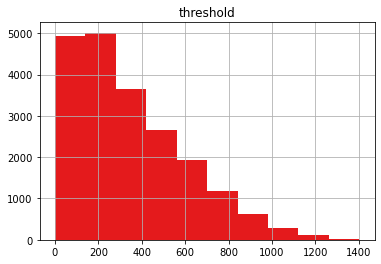

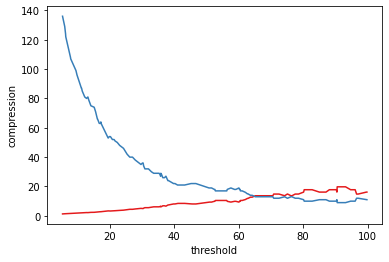

In [12]:
birch_threshold_plot(X_not_scaled, True, ds_not_scaled)

# Unsupervised UMAP

## Not Scaled

In [13]:
umap_not_scaled_cp = ClusterPlot(dim_reduction_algo='umap',
            reduce_all_points=True,
            n_iter=1, 
            batch_size=0,
            learning_rate=0.1,
            do_animation=False,
            dataset='Wine',
            class_to_label=ds_not_scaled.class_to_label,
            show_fig=True,
            save_fig=True,
            random_state=RANDOM_STATE,
            show_anchors=False,
            supervised=False,
            show_points=True,
            show_inner_blobs=False,
            show_blobs=False,
            show_label_level_plots=True,
            show_anchor_level_plot=False,
            annotate_images=False,
#             birch_threshold=0.4,  # scaled features
            birch_threshold=20)
print(umap_not_scaled_cp)

ClusterPlot
addr:@7fd278
verbose=20
logger=<Logger ClusterPlot-56422 (INFO)>
n_components=2
anchors_method='birch'
n_intra_anchors=None
birch_threshold=20
birch_branching_factor=None
dim_reduction_algo='umap'
supervised=False
umap_n_neighbors=15
umap_min_dist=1
tsne_perplexity=30.0
reduce_all_points=True
uniform_points_per='anchor'
k=20
proximity_k=3
self_relation=False
radius_q=None
do_relaxation=True
top_greedy=1
magnitude_step=False
n_iter=1
batch_size=0
stop_criteria=1e-05
loss_func=<function ClusterPlot._l_inf_loss at 0x0000017F0FF38F28>
loss='Linf'
only_inter_relations=False
learning_rate=0.1
mask_sparse_subcluster=None
random_points_method='voronoi'
class_to_label={0: 'class_0', 1: 'class_1', 2: 'class_2'}
random_state=42
n_jobs=None
dataset='Wine'
show_fig=True
save_fig=True
figsize=(21, 15)
do_animation=False
use_spline=False
alpha=None
remove_outliers_k=None
douglas_peucker_tolerance=0.6
smooth_iter=3
skip_polygons_with_area=0.01
mask_relation_in_same_label=True
save_fig_ever

2021-09-11 22:23:26,549 - ClusterPlot-56422 - INFO - finding intra class anchors using birch
2021-09-11 22:23:26,639 - ClusterPlot-56422 - INFO - UnSupervised Dim Reduction
2021-09-11 22:23:26,640 - ClusterPlot-56422 - INFO - Dim Reduction all points
2021-09-11 22:23:36,538 - ClusterPlot-56422 - INFO - Starting iteration 1 loss = 0.21052631578947367


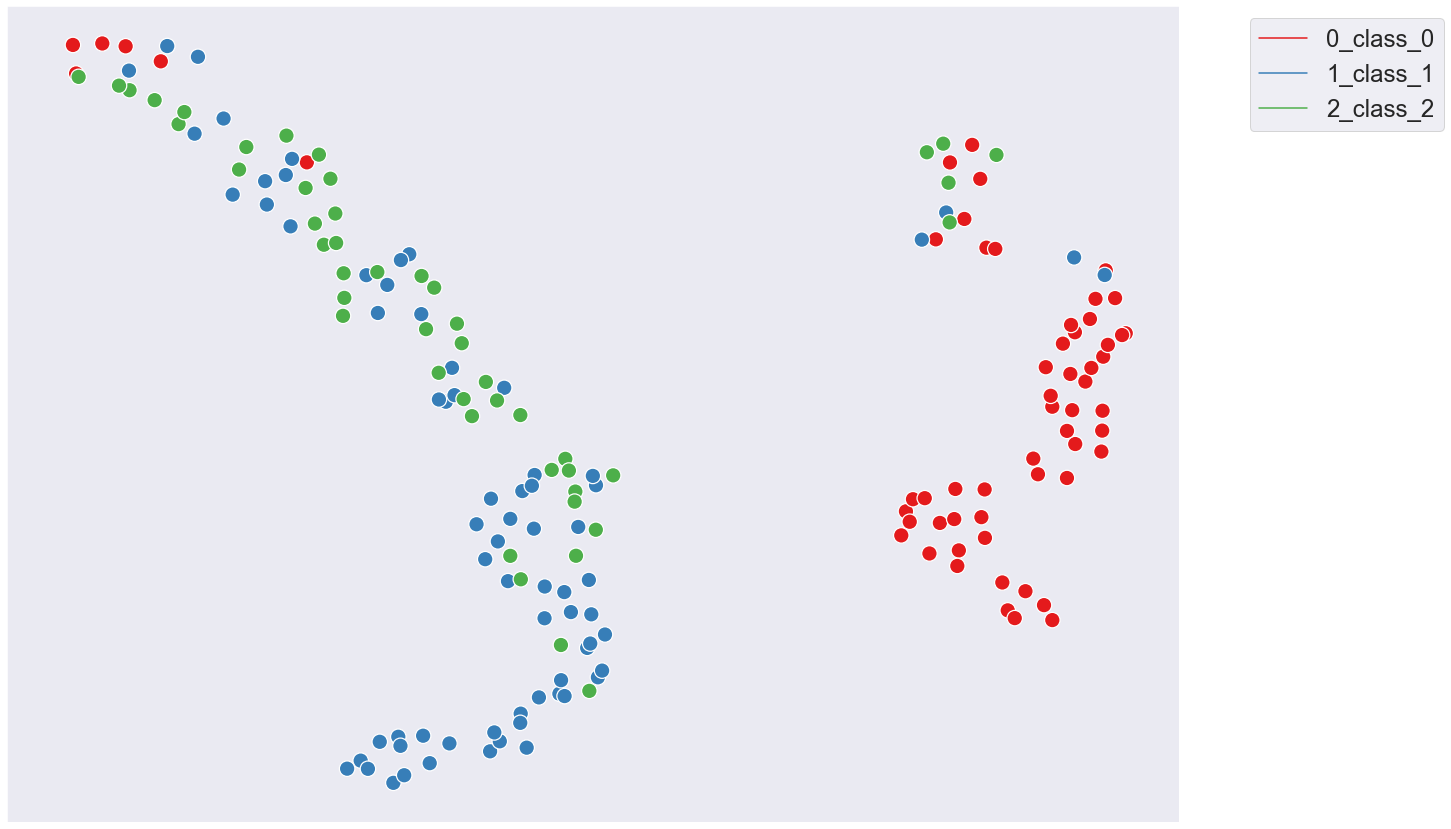

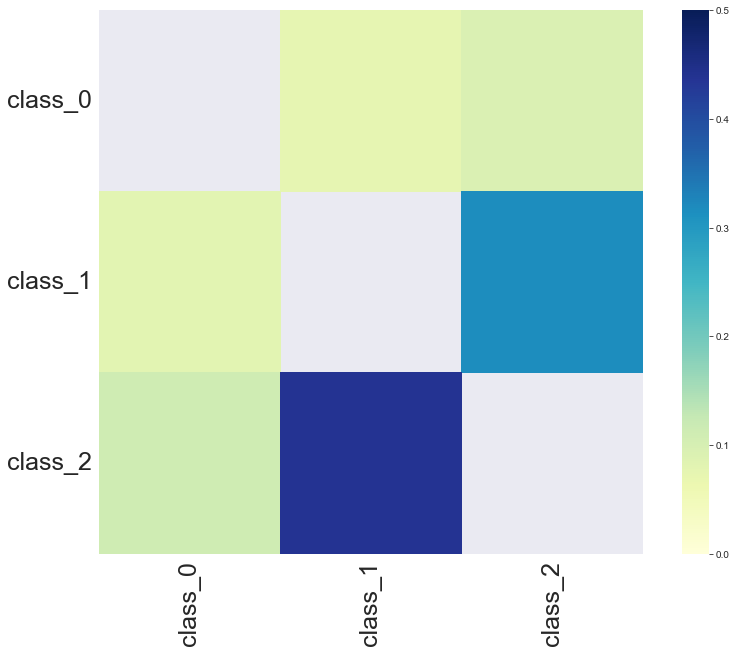

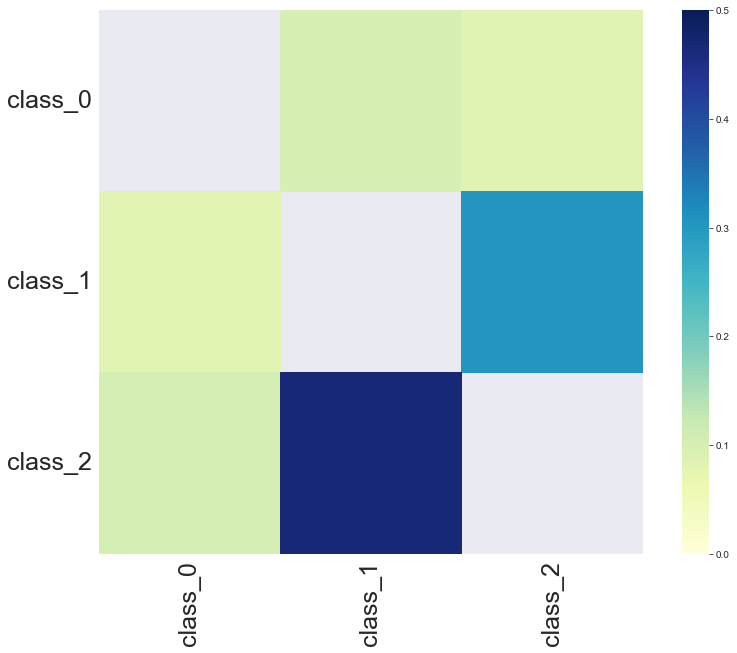

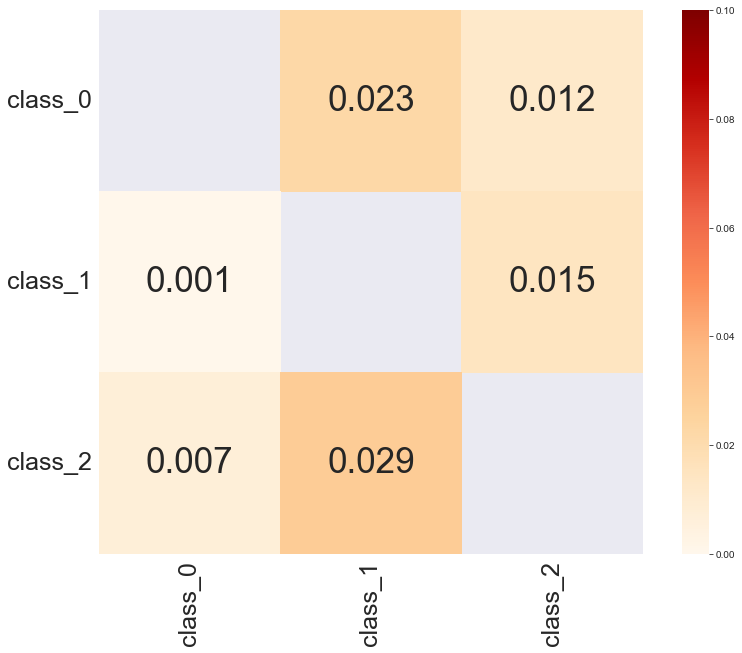

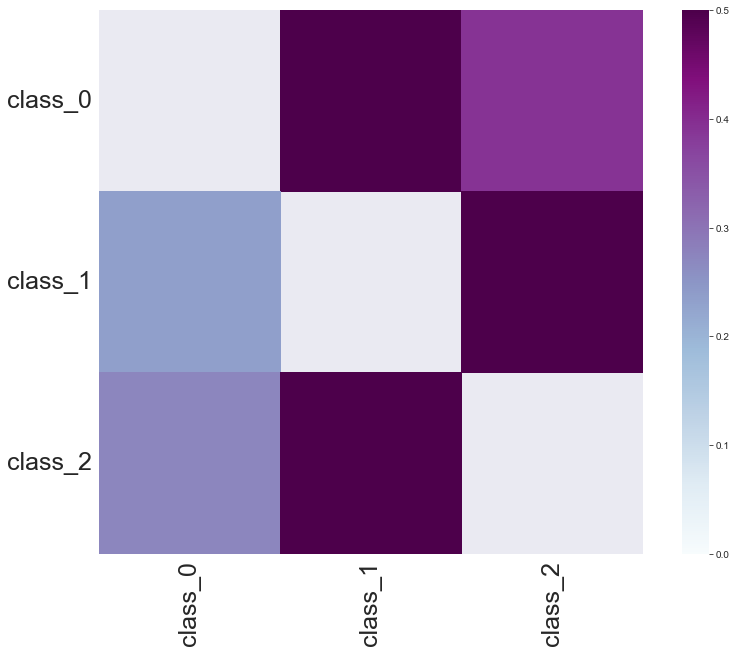

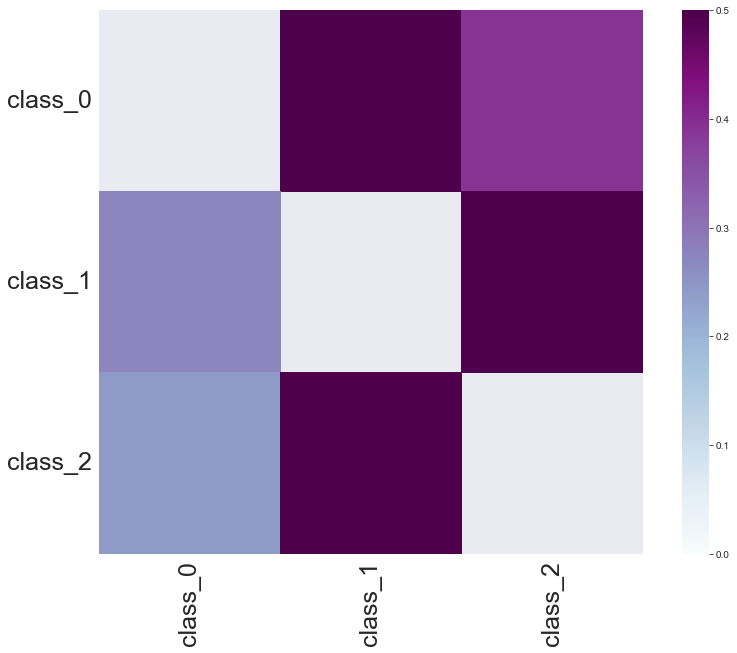

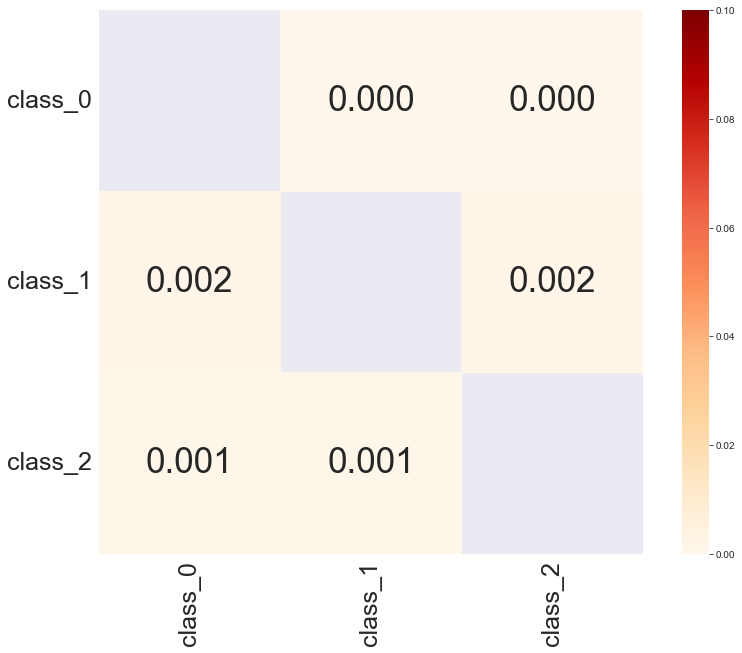

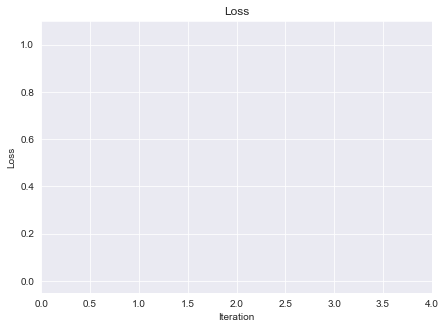

In [14]:
low_dim_umap = umap_not_scaled_cp.fit_transform(X_not_scaled, y_not_scaled)

## Scaled

In [15]:
umap_scaled_cp = ClusterPlot(dim_reduction_algo='umap',
            reduce_all_points=True,
            n_iter=1, 
            batch_size=0,
            learning_rate=0.1,
            do_animation=False,
            dataset='Wine',
            class_to_label=ds_scaled.class_to_label,
            show_fig=True,
            save_fig=True,
            random_state=RANDOM_STATE,
            show_anchors=False,
            supervised=False,
            show_points=True,
            show_inner_blobs=False,
            show_blobs=False,
            show_label_level_plots=True,
            show_anchor_level_plot=False,
            annotate_images=False,
            birch_threshold=0.4)
print(umap_scaled_cp)

ClusterPlot
addr:@7f6be0
verbose=20
logger=<Logger ClusterPlot-56422 (INFO)>
n_components=2
anchors_method='birch'
n_intra_anchors=None
birch_threshold=0.4
birch_branching_factor=None
dim_reduction_algo='umap'
supervised=False
umap_n_neighbors=15
umap_min_dist=1
tsne_perplexity=30.0
reduce_all_points=True
uniform_points_per='anchor'
k=20
proximity_k=3
self_relation=False
radius_q=None
do_relaxation=True
top_greedy=1
magnitude_step=False
n_iter=1
batch_size=0
stop_criteria=1e-05
loss_func=<function ClusterPlot._l_inf_loss at 0x0000017F0FF38F28>
loss='Linf'
only_inter_relations=False
learning_rate=0.1
mask_sparse_subcluster=None
random_points_method='voronoi'
class_to_label={0: 'class_0', 1: 'class_1', 2: 'class_2'}
random_state=42
n_jobs=None
dataset='Wine'
show_fig=True
save_fig=True
figsize=(21, 15)
do_animation=False
use_spline=False
alpha=None
remove_outliers_k=None
douglas_peucker_tolerance=0.6
smooth_iter=3
skip_polygons_with_area=0.01
mask_relation_in_same_label=True
save_fig_eve

2021-09-11 22:23:40,199 - ClusterPlot-56422 - INFO - finding intra class anchors using birch
2021-09-11 22:23:40,199 - ClusterPlot-56422 - INFO - finding intra class anchors using birch
2021-09-11 22:23:40,284 - ClusterPlot-56422 - INFO - UnSupervised Dim Reduction
2021-09-11 22:23:40,284 - ClusterPlot-56422 - INFO - UnSupervised Dim Reduction
2021-09-11 22:23:40,286 - ClusterPlot-56422 - INFO - Dim Reduction all points
2021-09-11 22:23:40,286 - ClusterPlot-56422 - INFO - Dim Reduction all points
2021-09-11 22:23:42,094 - ClusterPlot-56422 - INFO - Starting iteration 1 loss = 0.34210526315789475
2021-09-11 22:23:42,094 - ClusterPlot-56422 - INFO - Starting iteration 1 loss = 0.34210526315789475


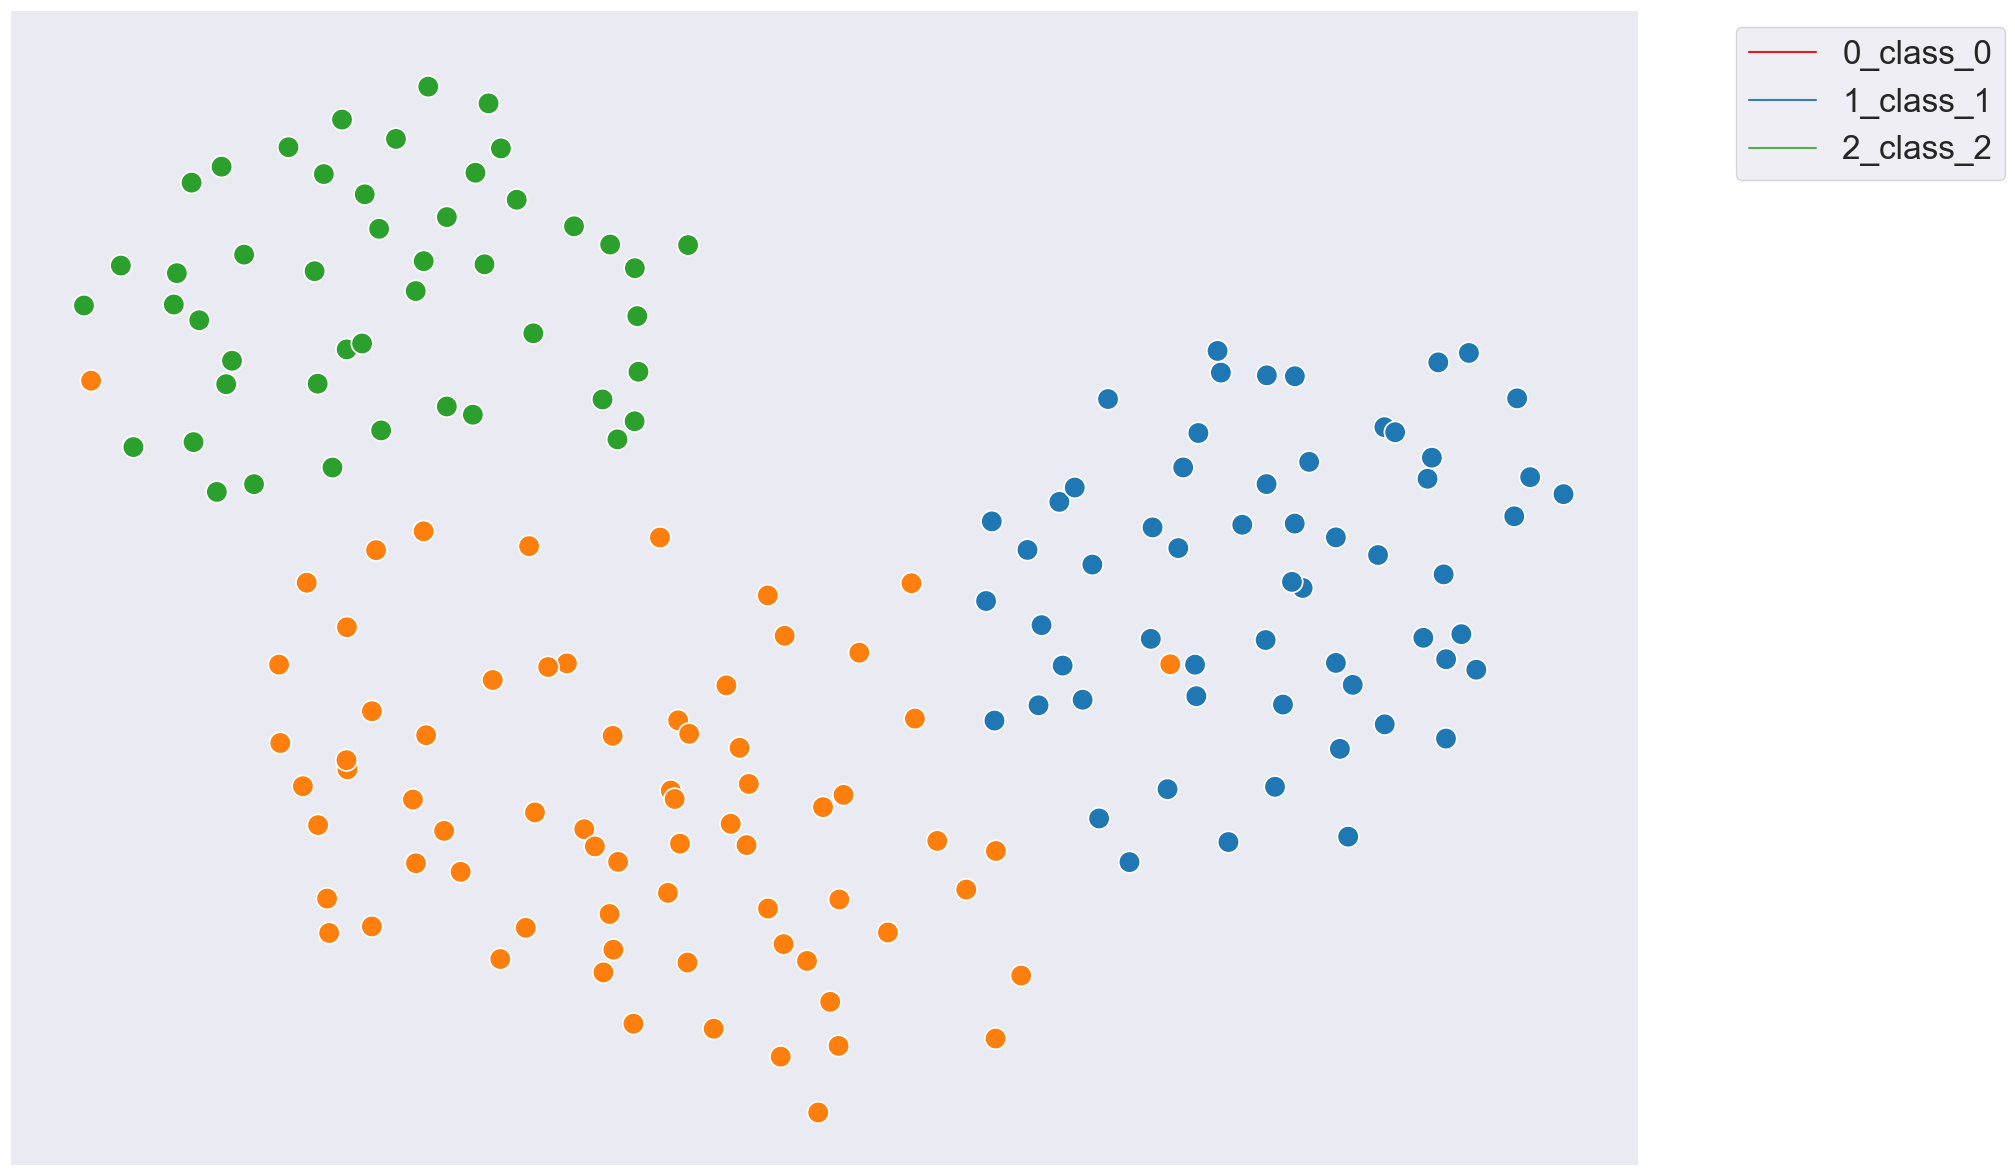

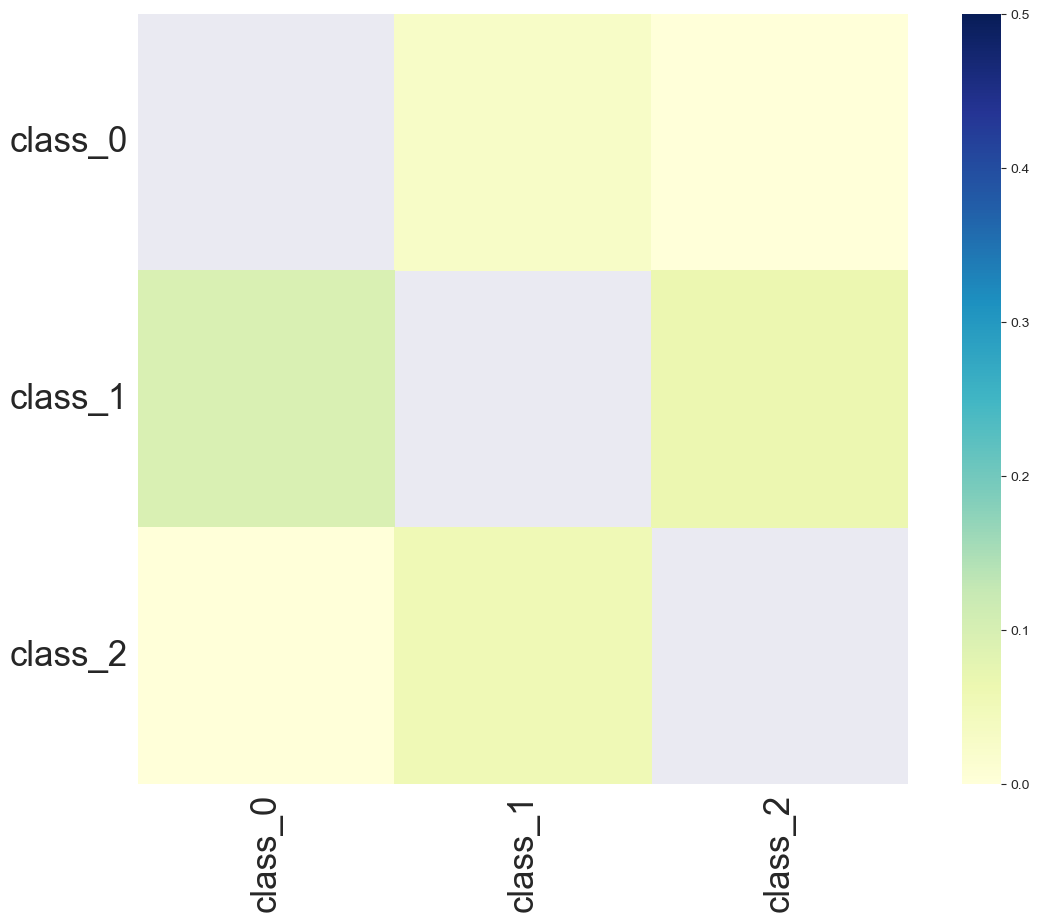

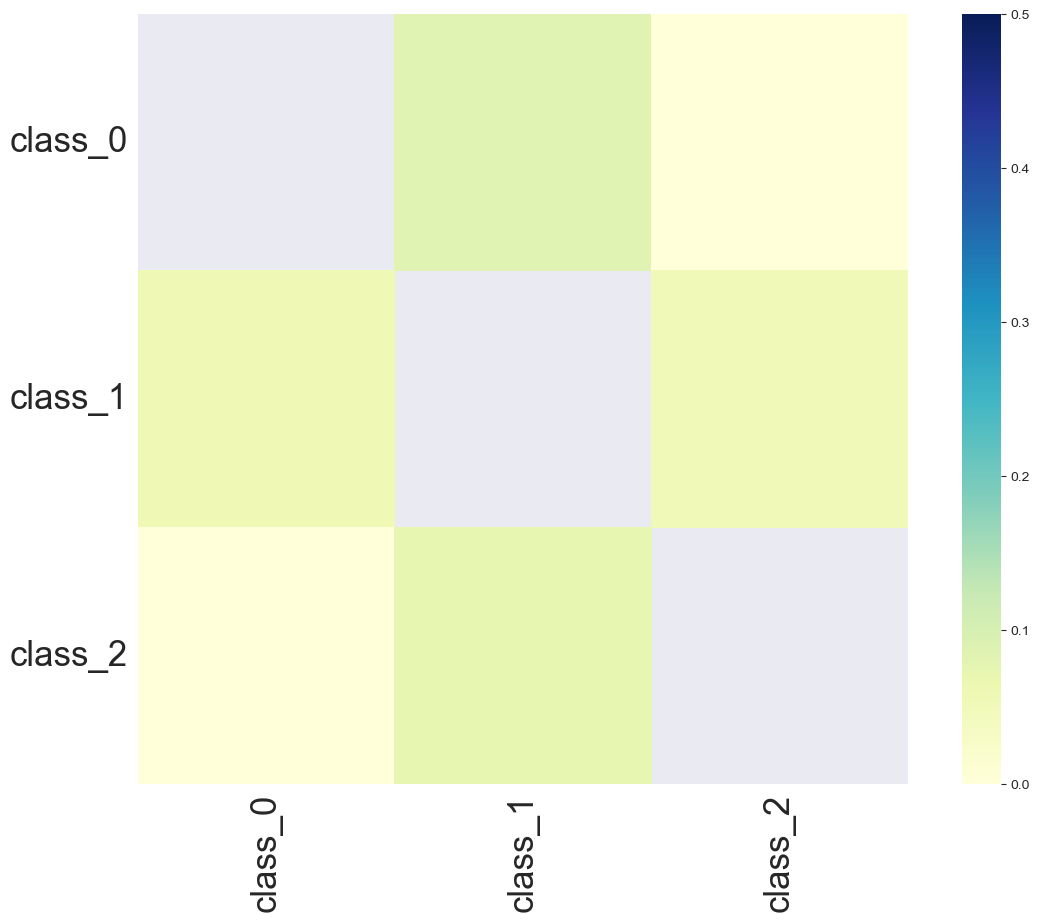

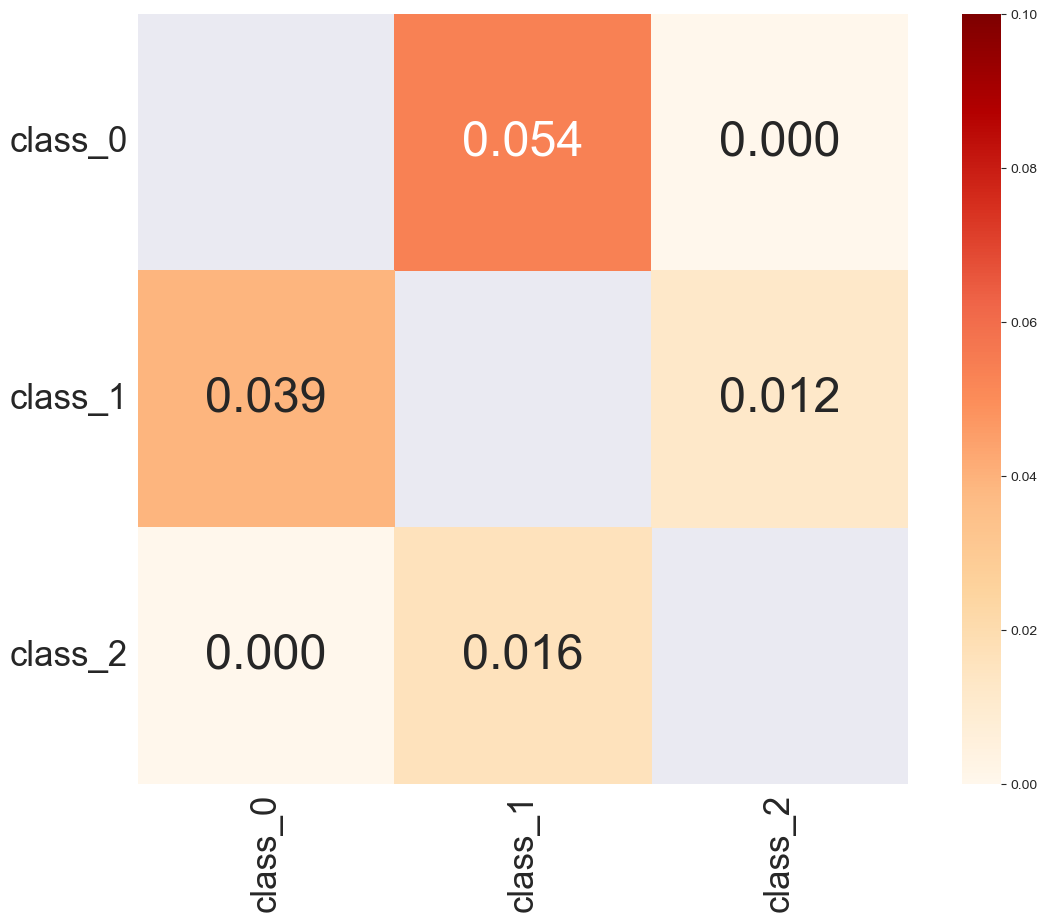

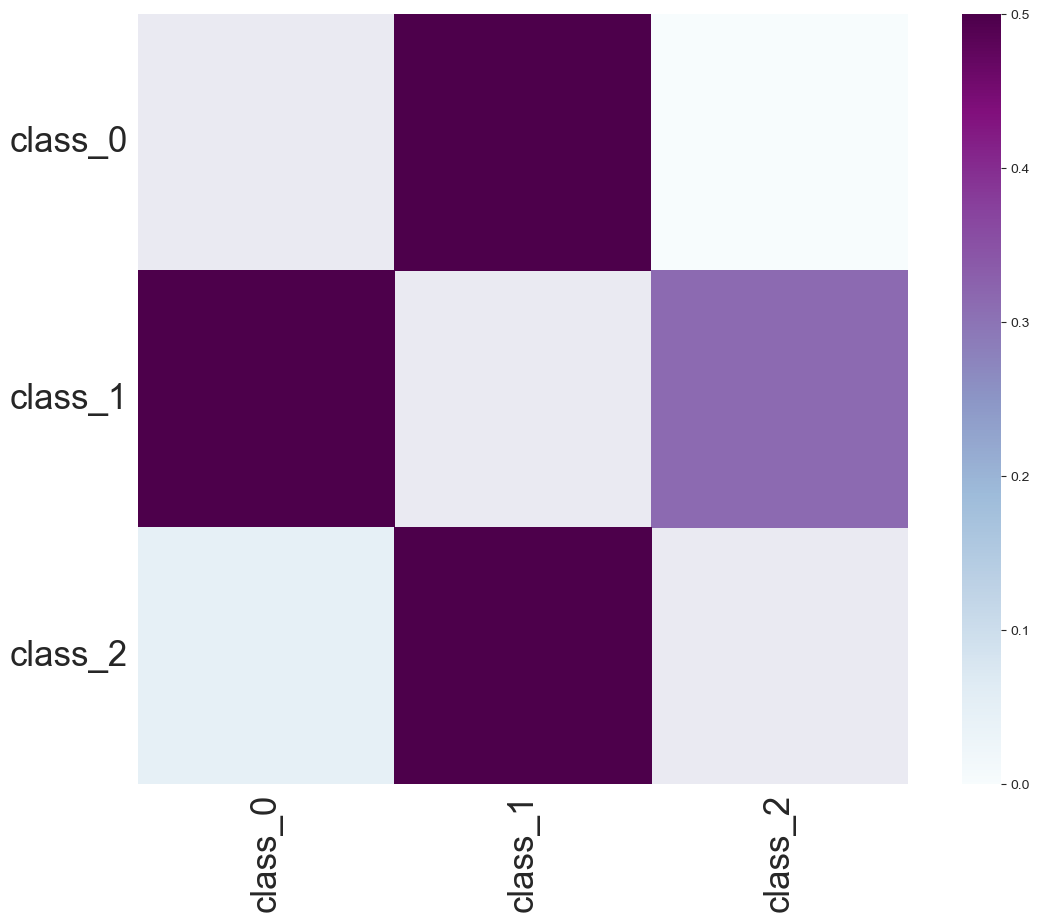

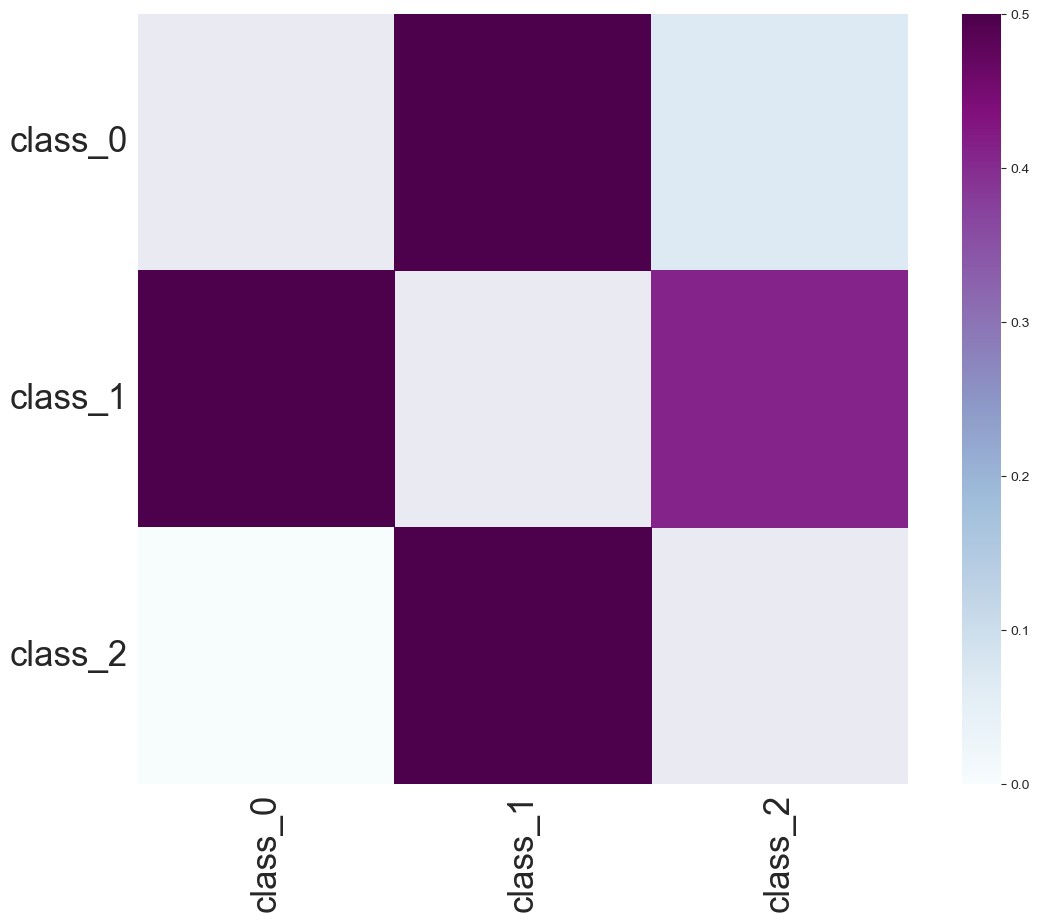

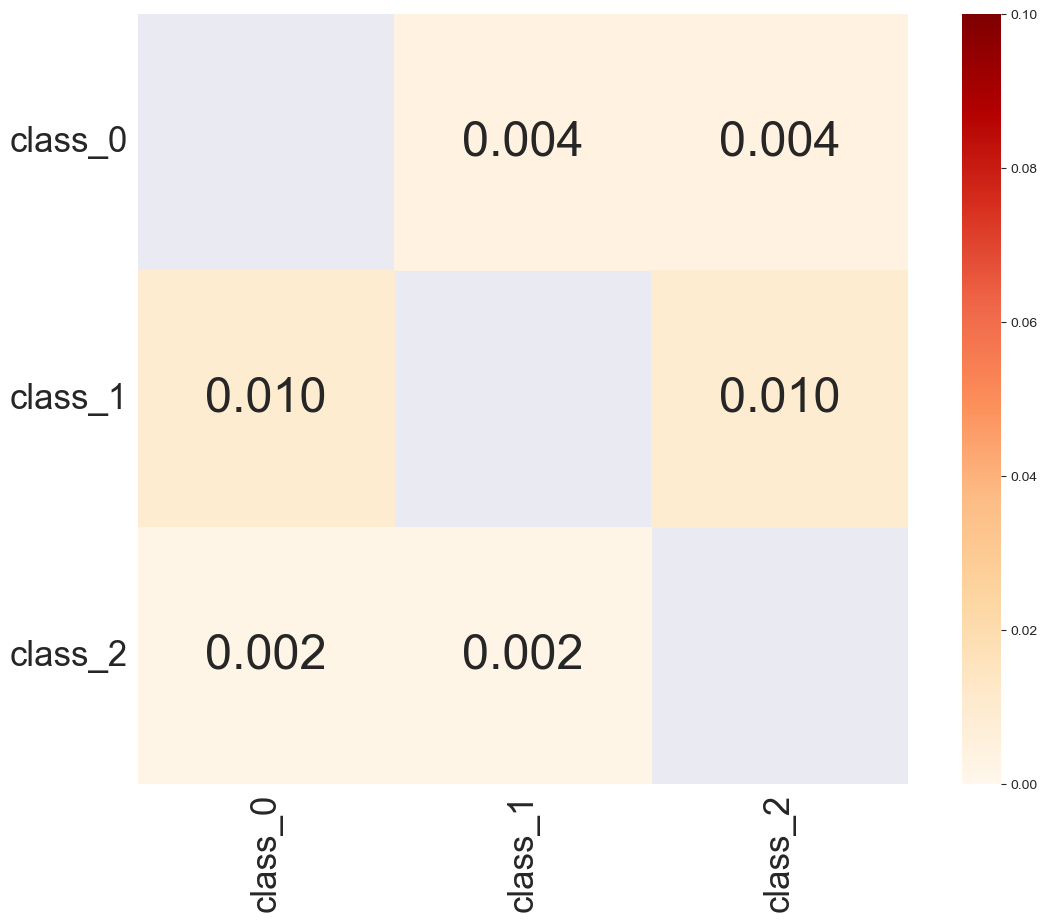

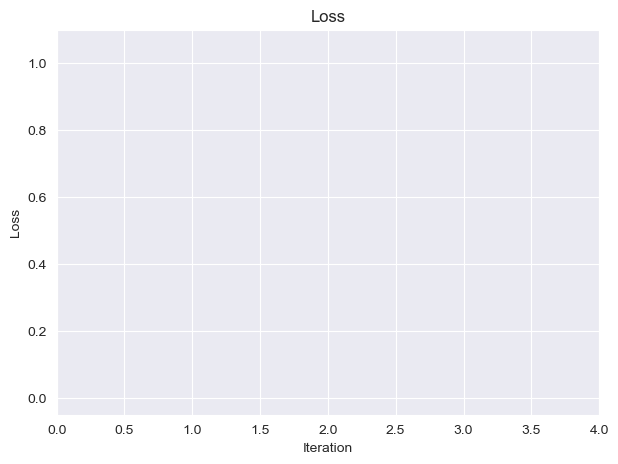

In [16]:
low_dim_umap = umap_scaled_cp.fit_transform(X_scaled, y_scaled)

# ClusterPlot

## Not Scaled

In [17]:
blobs_not_scaled_cp = ClusterPlot(reduce_all_points=False,
                  n_iter=1, 
                  batch_size=0,
                  learning_rate=0.5,
                  dataset='Wine',
                  class_to_label=ds_not_scaled.class_to_label,
                  show_fig=True,
                  save_fig=True,
                  random_state=RANDOM_STATE,
                  show_anchors=False,
                  supervised=False,
                  show_points=False,
                  show_inner_blobs=False,
                  show_blobs=True,
                  show_label_level_plots=True,
                  show_anchor_level_plot=False,
                  save_fig_every=20,
                  annotate_images=False,
#                   birch_threshold=0.4,  # scaled features
                  birch_threshold=50,
                  alpha=0,
                  douglas_peucker_tolerance=0.1,
                  smooth_iter=3,
                  magnitude_step=True,
                  mask_sparse_subcluster=0,
                  top_greedy=3)
print(blobs_not_scaled_cp)

ClusterPlot
addr:@e7c080
verbose=20
logger=<Logger ClusterPlot-56422 (INFO)>
n_components=2
anchors_method='birch'
n_intra_anchors=None
birch_threshold=50
birch_branching_factor=None
dim_reduction_algo='umap'
supervised=False
umap_n_neighbors=15
umap_min_dist=1
tsne_perplexity=30.0
reduce_all_points=False
uniform_points_per='anchor'
k=20
proximity_k=3
self_relation=False
radius_q=None
do_relaxation=True
top_greedy=3
magnitude_step=True
n_iter=1
batch_size=0
stop_criteria=1e-05
loss_func=<function ClusterPlot._l_inf_loss at 0x0000017F0FF38F28>
loss='Linf'
only_inter_relations=False
learning_rate=0.5
mask_sparse_subcluster=0
random_points_method='voronoi'
class_to_label={0: 'class_0', 1: 'class_1', 2: 'class_2'}
random_state=42
n_jobs=None
dataset='Wine'
show_fig=True
save_fig=True
figsize=(21, 15)
do_animation=False
use_spline=False
alpha=0
remove_outliers_k=None
douglas_peucker_tolerance=0.1
smooth_iter=3
skip_polygons_with_area=0.01
mask_relation_in_same_label=True
save_fig_every=20
s

2021-09-11 22:23:46,213 - ClusterPlot-56422 - INFO - finding intra class anchors using birch
2021-09-11 22:23:46,213 - ClusterPlot-56422 - INFO - finding intra class anchors using birch
2021-09-11 22:23:46,213 - ClusterPlot-56422 - INFO - finding intra class anchors using birch
2021-09-11 22:23:46,298 - ClusterPlot-56422 - INFO - UnSupervised Dim Reduction
2021-09-11 22:23:46,298 - ClusterPlot-56422 - INFO - UnSupervised Dim Reduction
2021-09-11 22:23:46,298 - ClusterPlot-56422 - INFO - UnSupervised Dim Reduction
2021-09-11 22:23:46,301 - ClusterPlot-56422 - INFO - Dim Reduction only anchors
2021-09-11 22:23:46,301 - ClusterPlot-56422 - INFO - Dim Reduction only anchors
2021-09-11 22:23:46,301 - ClusterPlot-56422 - INFO - Dim Reduction only anchors
2021-09-11 22:23:47,928 - ClusterPlot-56422 - INFO - Dim Reduction only anchors - generate random points in low dim per anchor
2021-09-11 22:23:47,928 - ClusterPlot-56422 - INFO - Dim Reduction only anchors - generate random points in low di

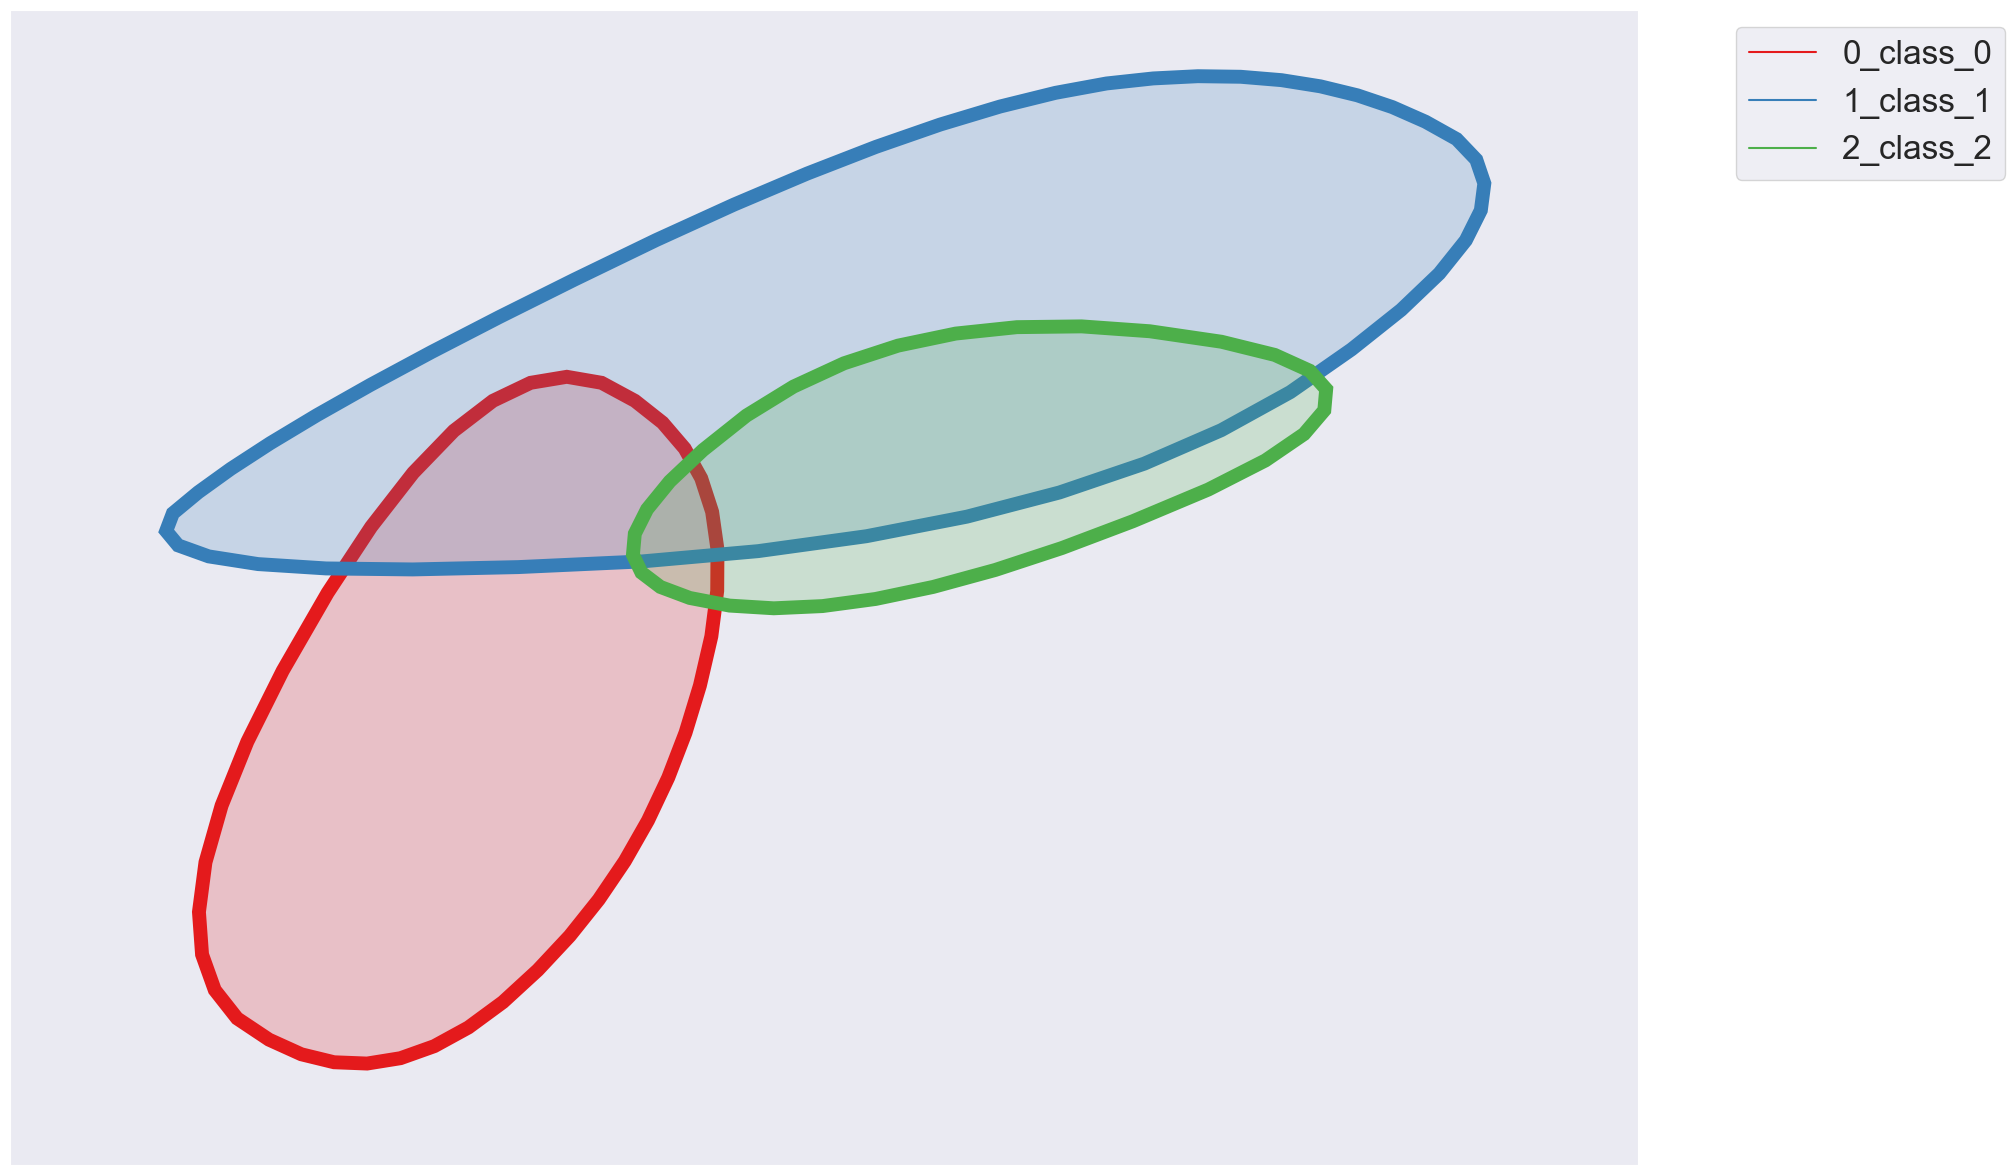

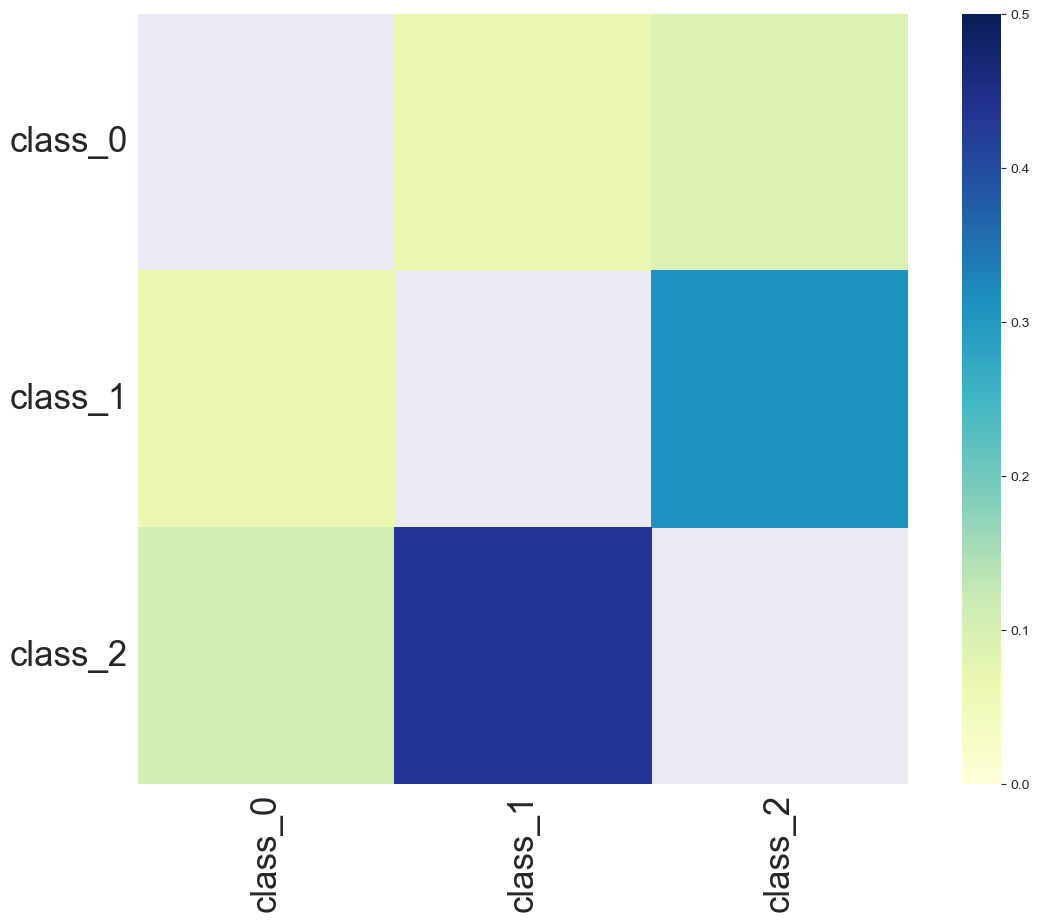

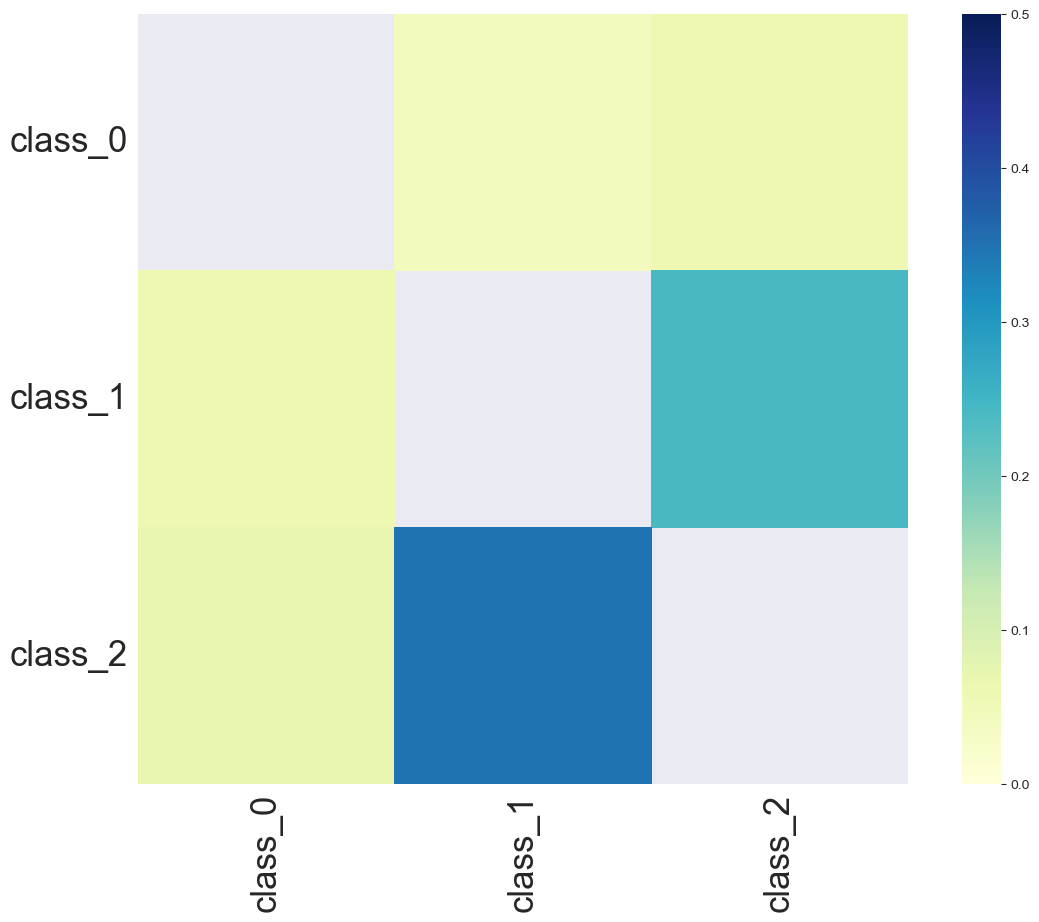

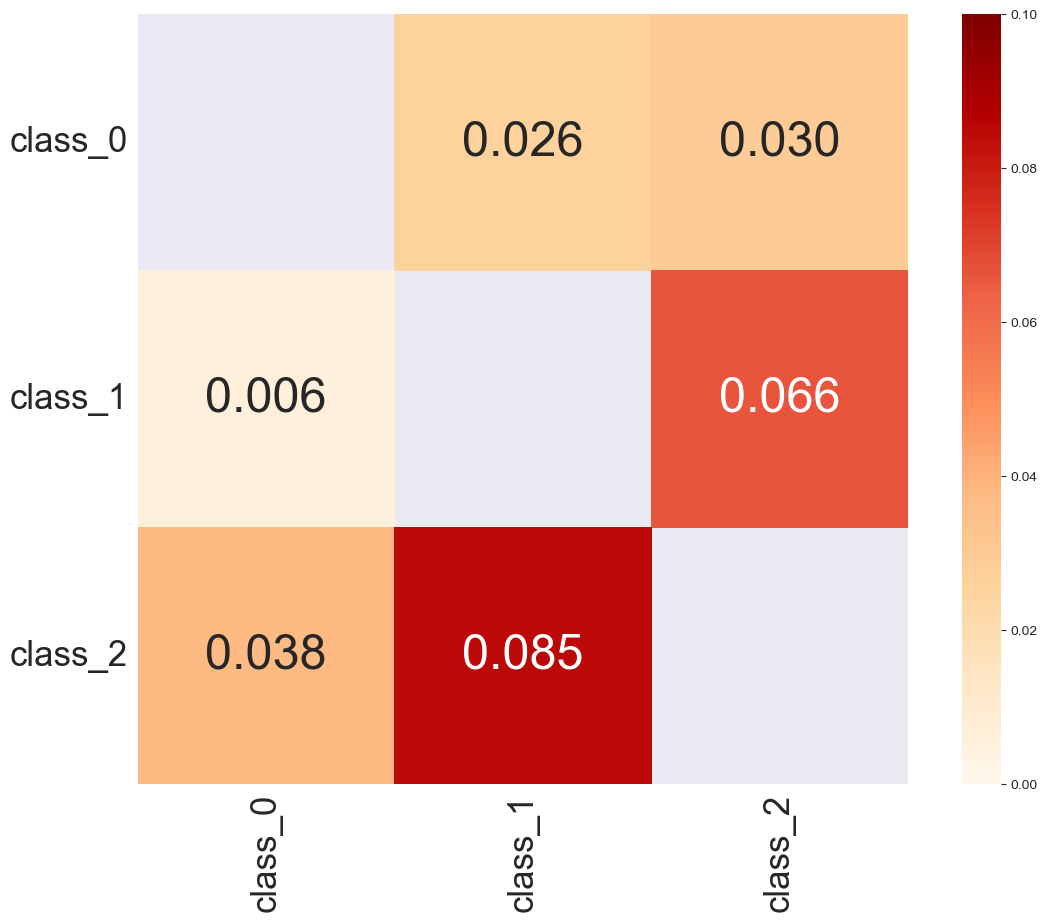

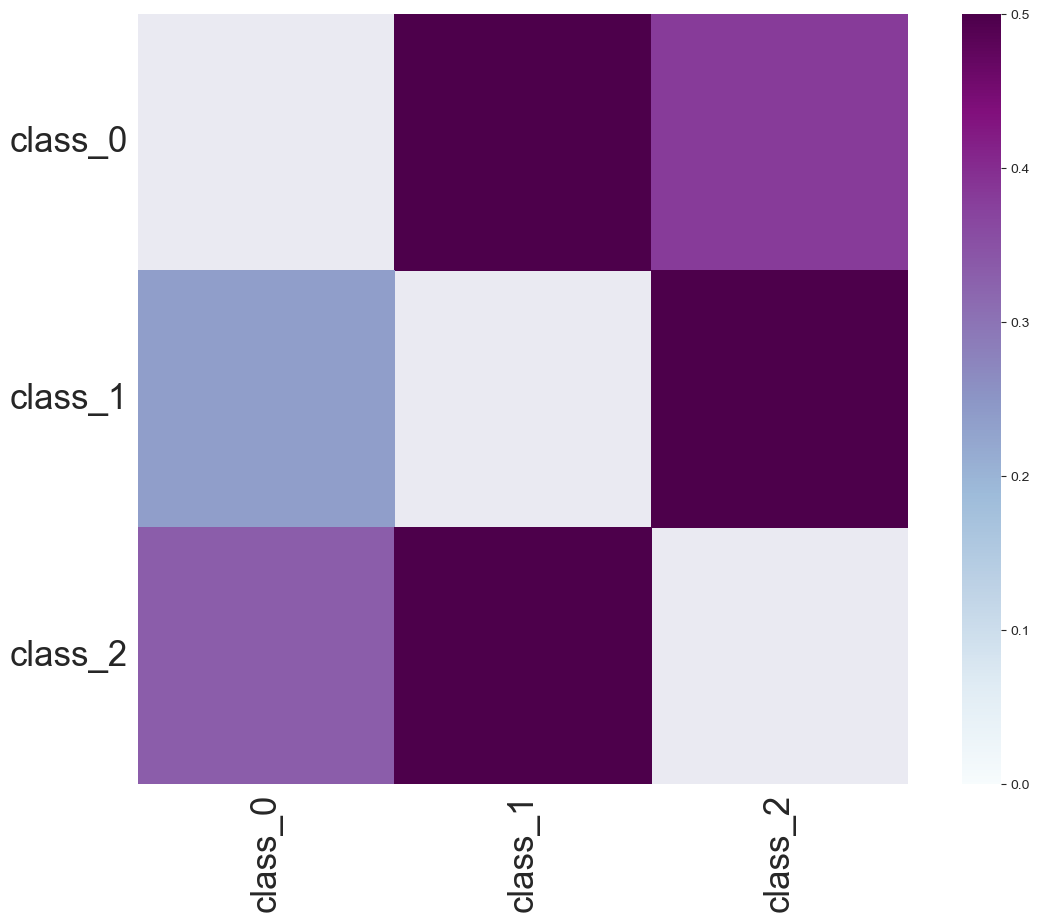

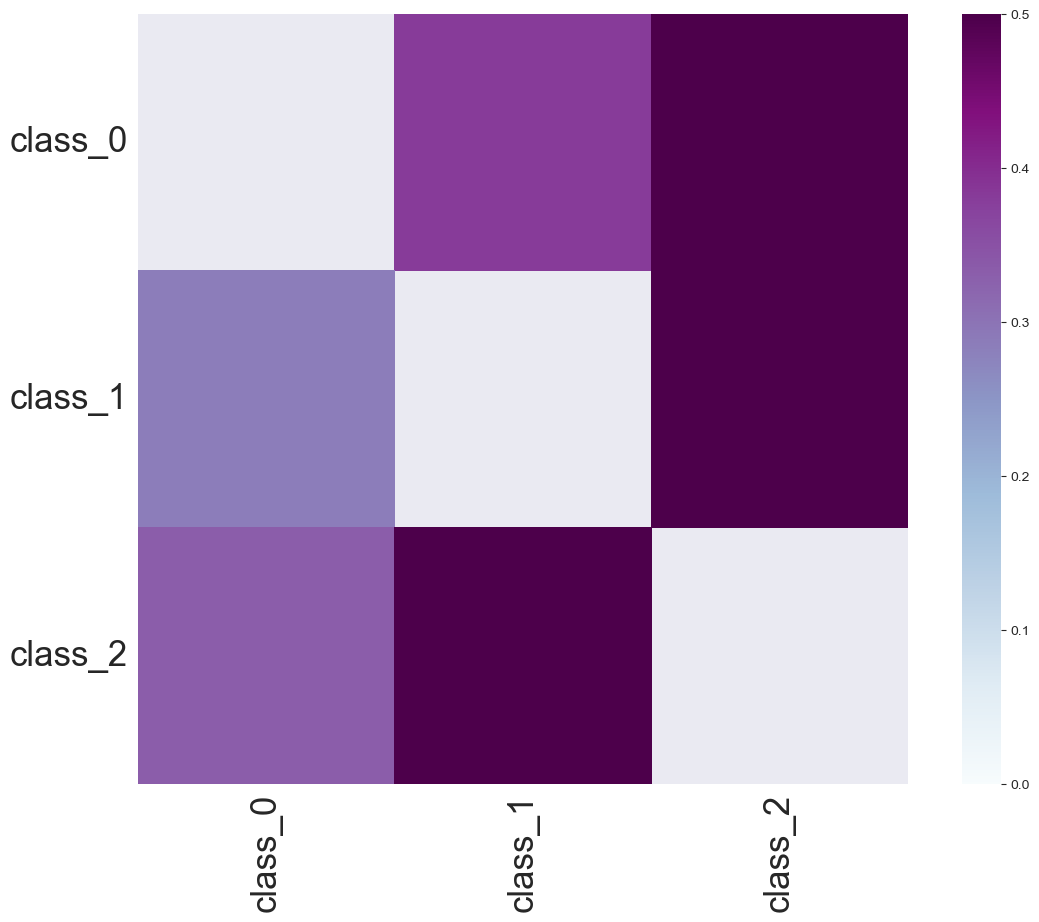

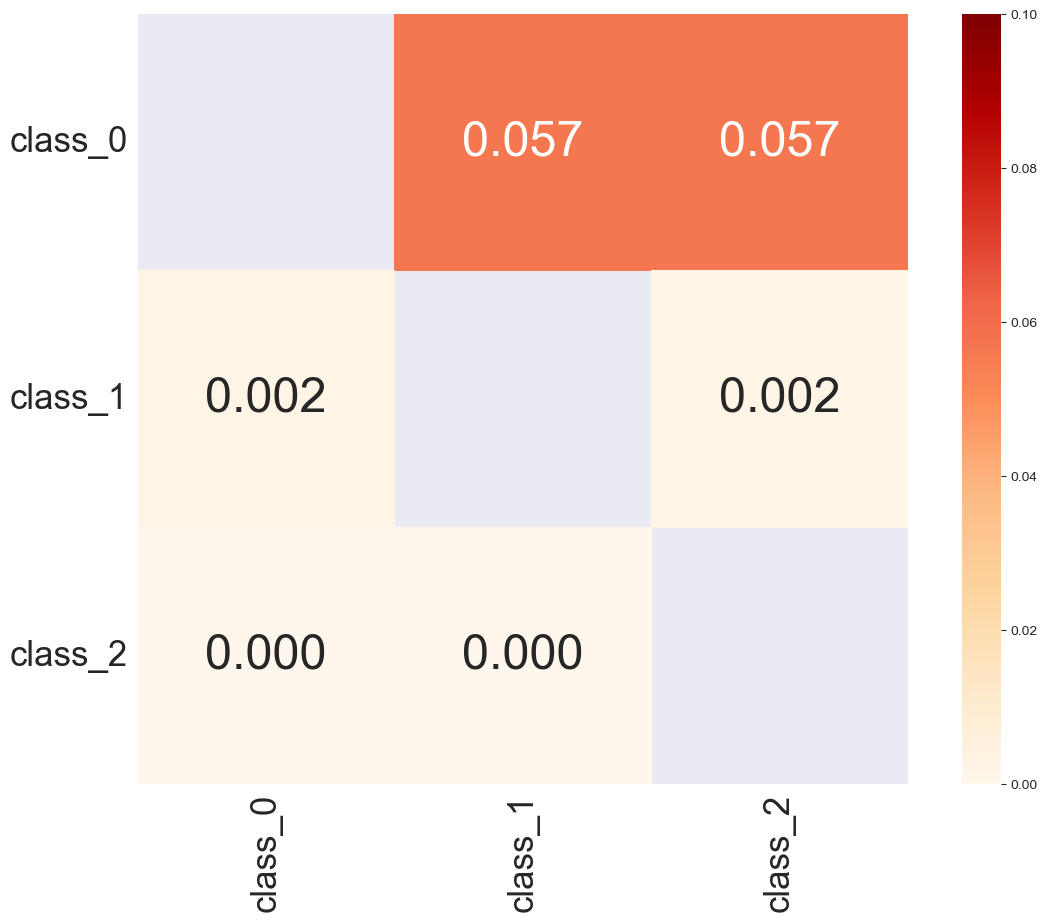

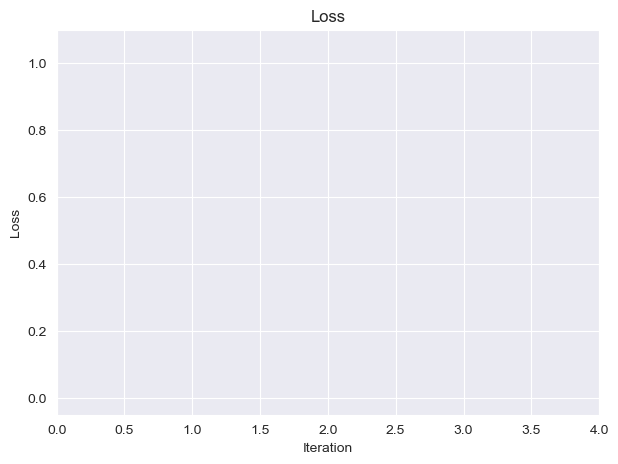

In [18]:
blobs_cp_low_dim = blobs_not_scaled_cp.fit_transform(X_not_scaled, y_not_scaled)

## Scaled

In [19]:
blobs_cp = ClusterPlot(reduce_all_points=False,
                  n_iter=41, 
                  batch_size=1,
                  learning_rate=0.5,
                  dataset='Wine',
                  class_to_label=ds_scaled.class_to_label,
                  show_fig=True,
                  save_fig=True,
                  random_state=RANDOM_STATE,
                  show_anchors=False,
                  supervised=False,
                  show_points=False,
                  show_inner_blobs=False,
                  show_blobs=True,
                  show_label_level_plots=True,
                  show_anchor_level_plot=False,
                  save_fig_every=40,
                  annotate_images=False,
                  birch_threshold=0.4,
                  alpha=0,
                  douglas_peucker_tolerance=0.1,
                  smooth_iter=3,
                  magnitude_step=True,
                  mask_sparse_subcluster=0,
                  top_greedy=3)
print(blobs_cp)

ClusterPlot
addr:@8bda58
verbose=20
logger=<Logger ClusterPlot-23869 (INFO)>
n_components=2
anchors_method='birch'
n_intra_anchors=None
birch_threshold=0.4
birch_branching_factor=None
dim_reduction_algo='umap'
supervised=False
umap_n_neighbors=15
umap_min_dist=1
tsne_perplexity=30.0
reduce_all_points=False
uniform_points_per='anchor'
k=20
proximity_k=3
self_relation=False
radius_q=None
do_relaxation=True
top_greedy=3
magnitude_step=True
n_iter=41
batch_size=1
stop_criteria=1e-05
loss_func=<function ClusterPlot._l_inf_loss at 0x0000017F0FF38F28>
loss='Linf'
only_inter_relations=False
learning_rate=0.5
mask_sparse_subcluster=0
random_points_method='voronoi'
class_to_label={0: 'class_0', 1: 'class_1', 2: 'class_2'}
random_state=42
n_jobs=None
dataset='Wine'
show_fig=True
save_fig=True
figsize=(21, 15)
do_animation=False
use_spline=False
alpha=0
remove_outliers_k=None
douglas_peucker_tolerance=0.1
smooth_iter=3
skip_polygons_with_area=0.01
mask_relation_in_same_label=True
save_fig_every=40

2021-09-11 22:23:52,516 - ClusterPlot-23869 - INFO - finding intra class anchors using birch
2021-09-11 22:23:52,600 - ClusterPlot-23869 - INFO - UnSupervised Dim Reduction
2021-09-11 22:23:52,601 - ClusterPlot-23869 - INFO - Dim Reduction only anchors
2021-09-11 22:23:54,202 - ClusterPlot-23869 - INFO - Dim Reduction only anchors - generate random points in low dim per anchor
100%|██████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 1056.50it/s]
2021-09-11 22:23:54,467 - ClusterPlot-23869 - INFO - Starting iteration 1 loss = 0.5789473684210527


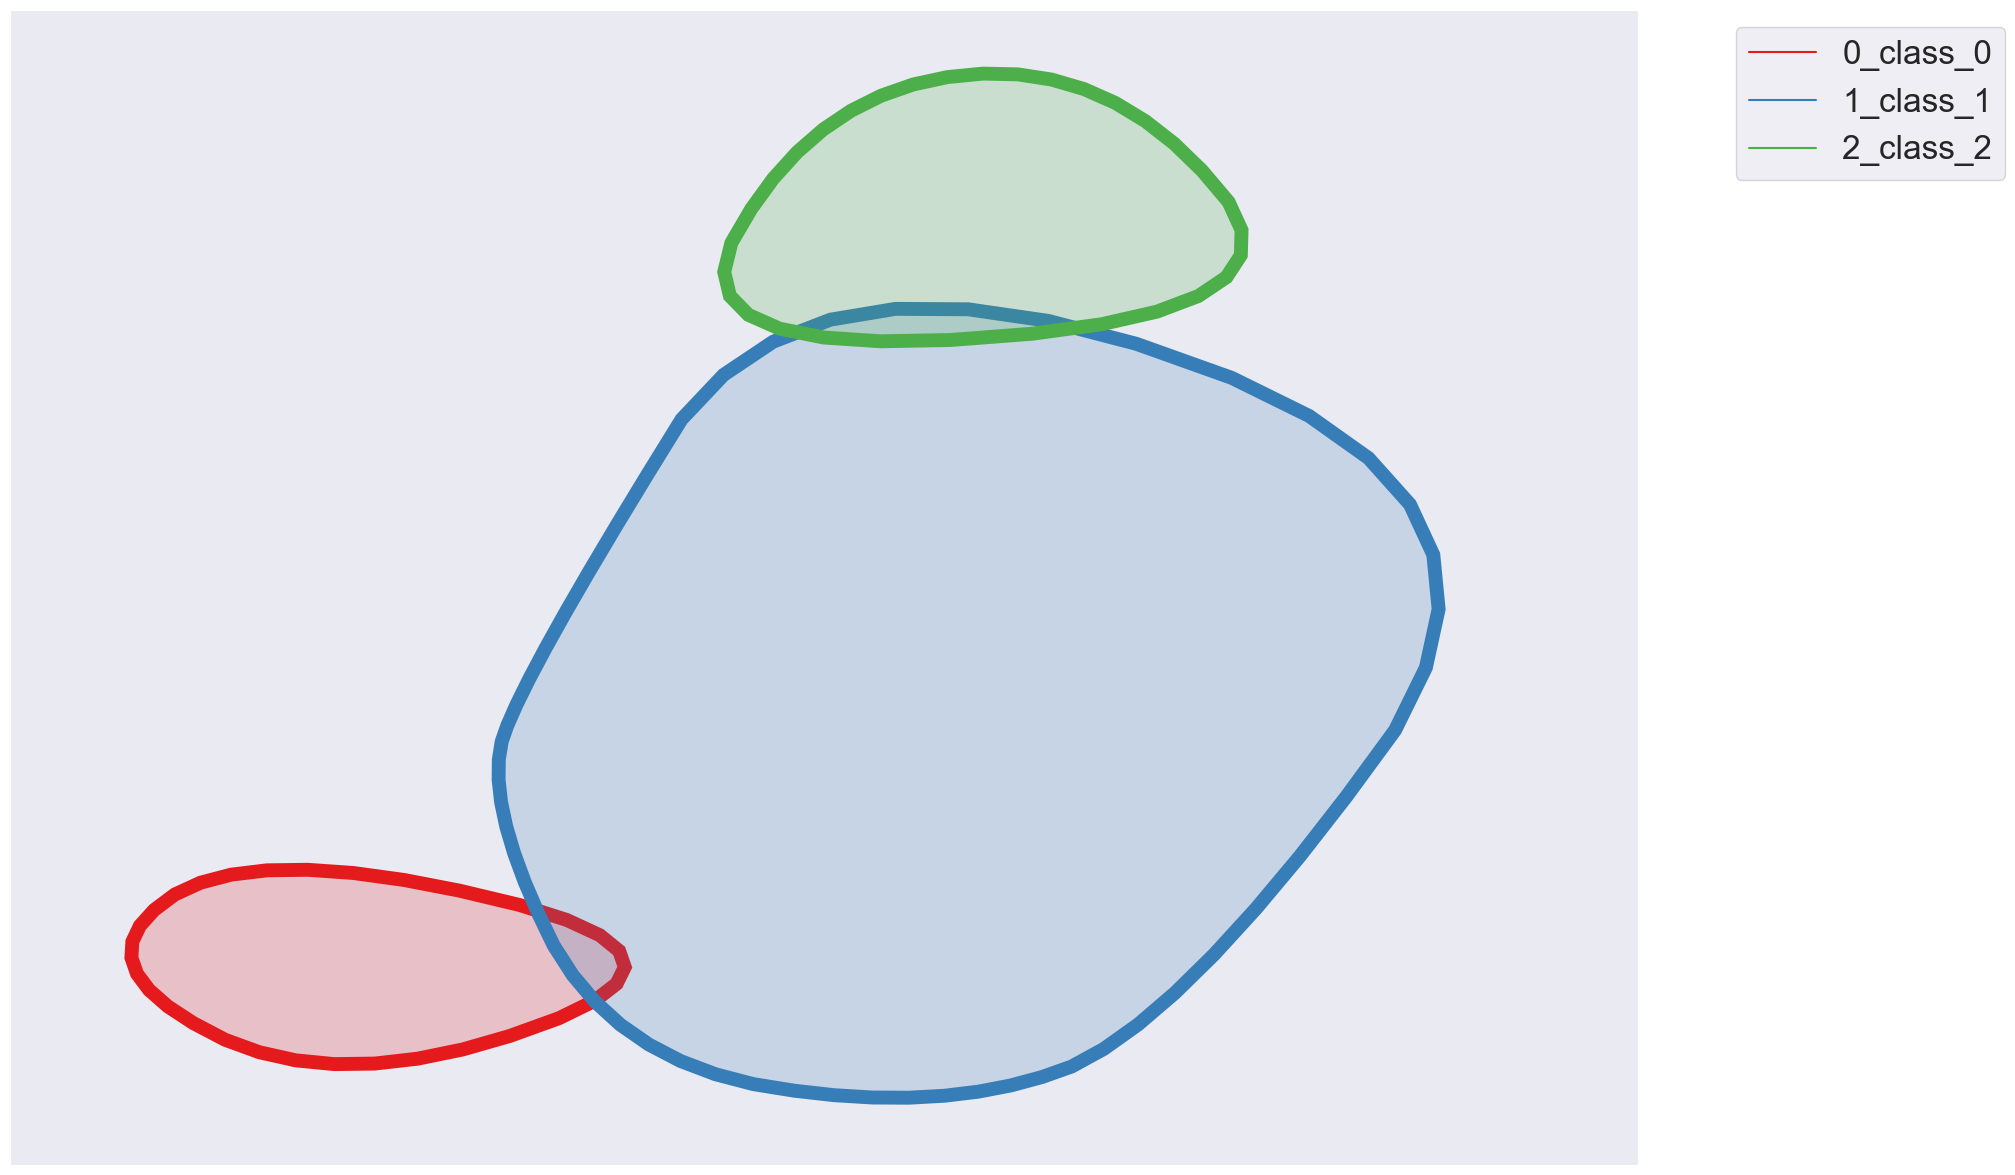

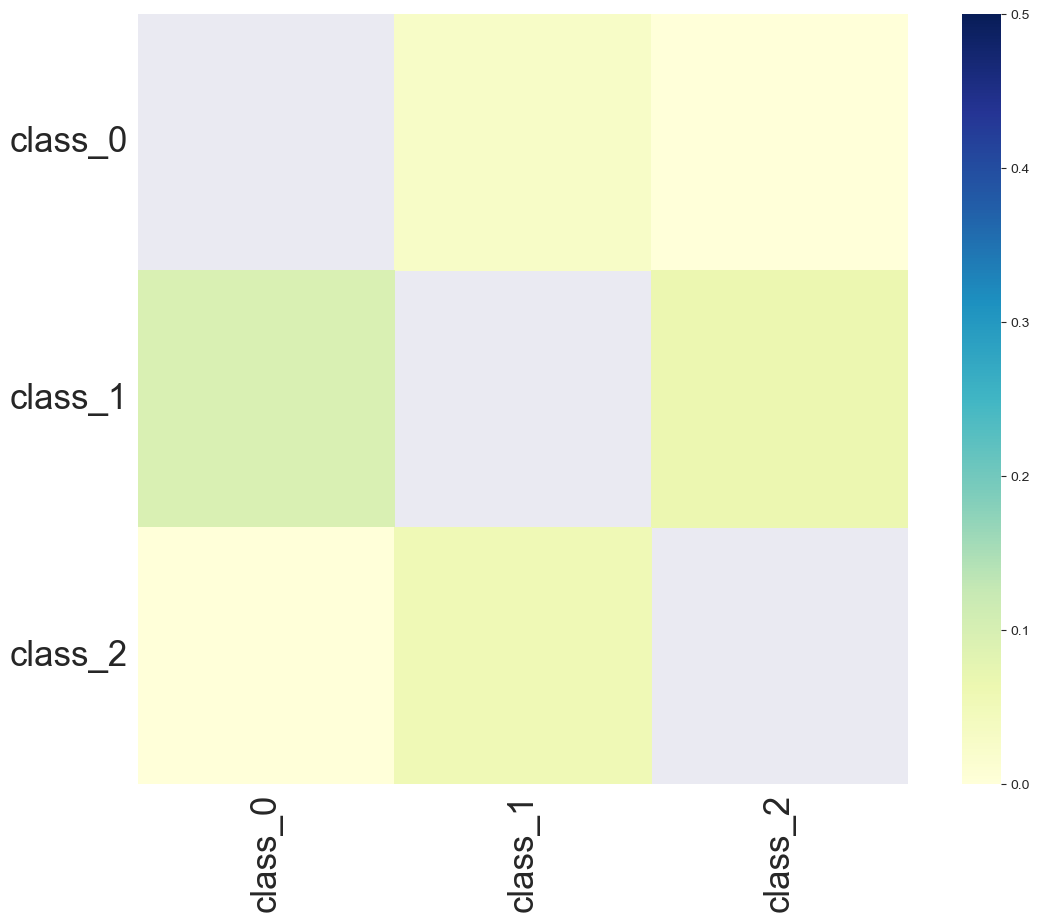

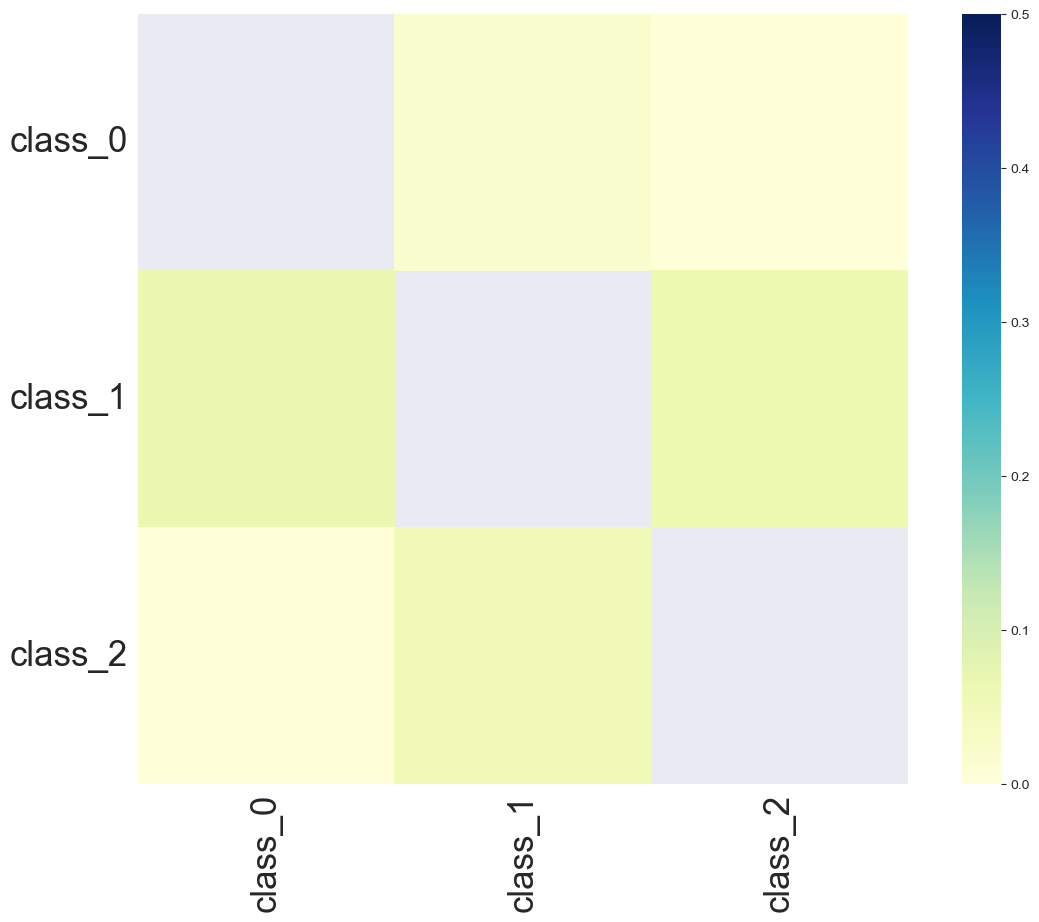

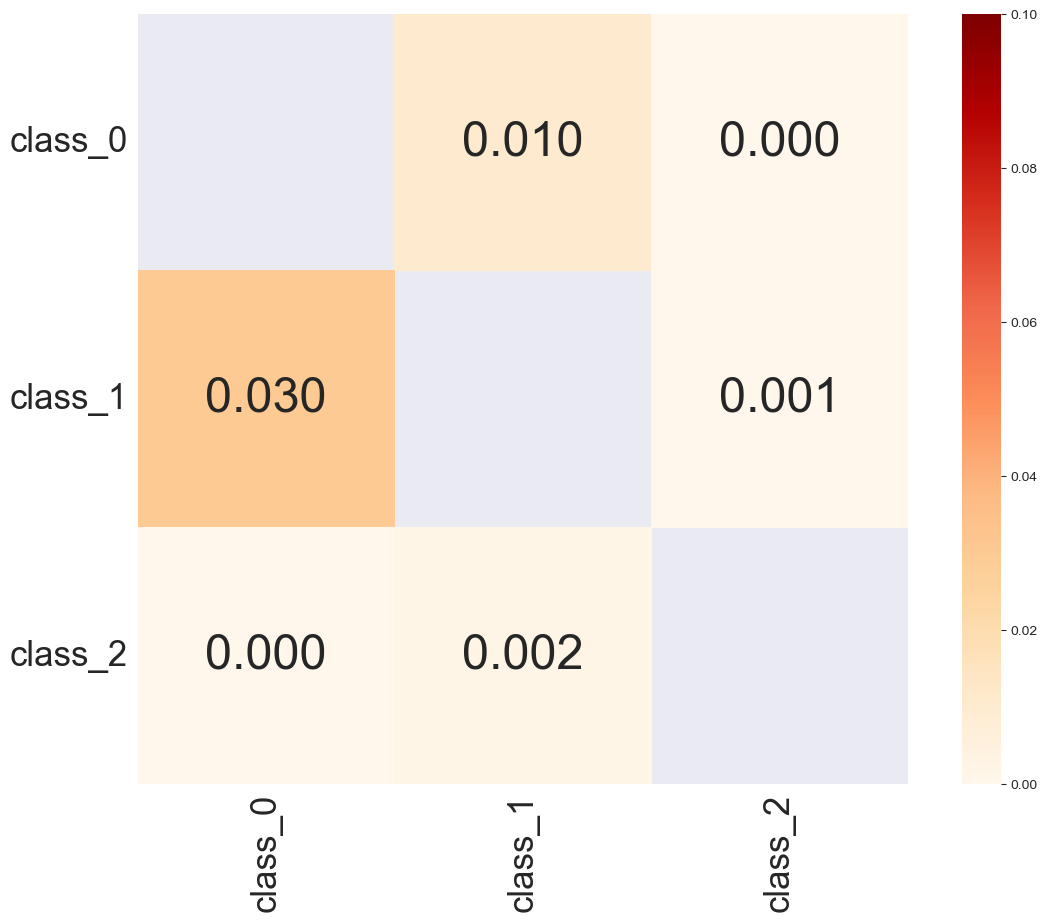

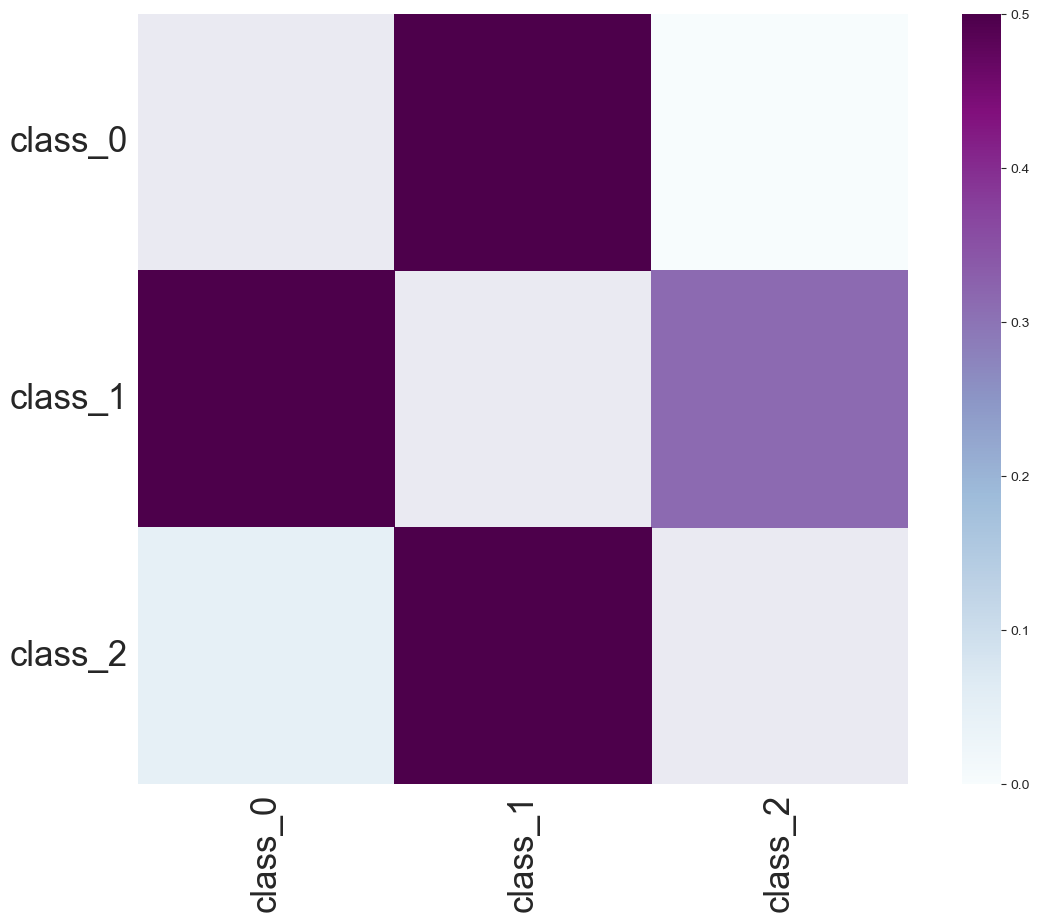

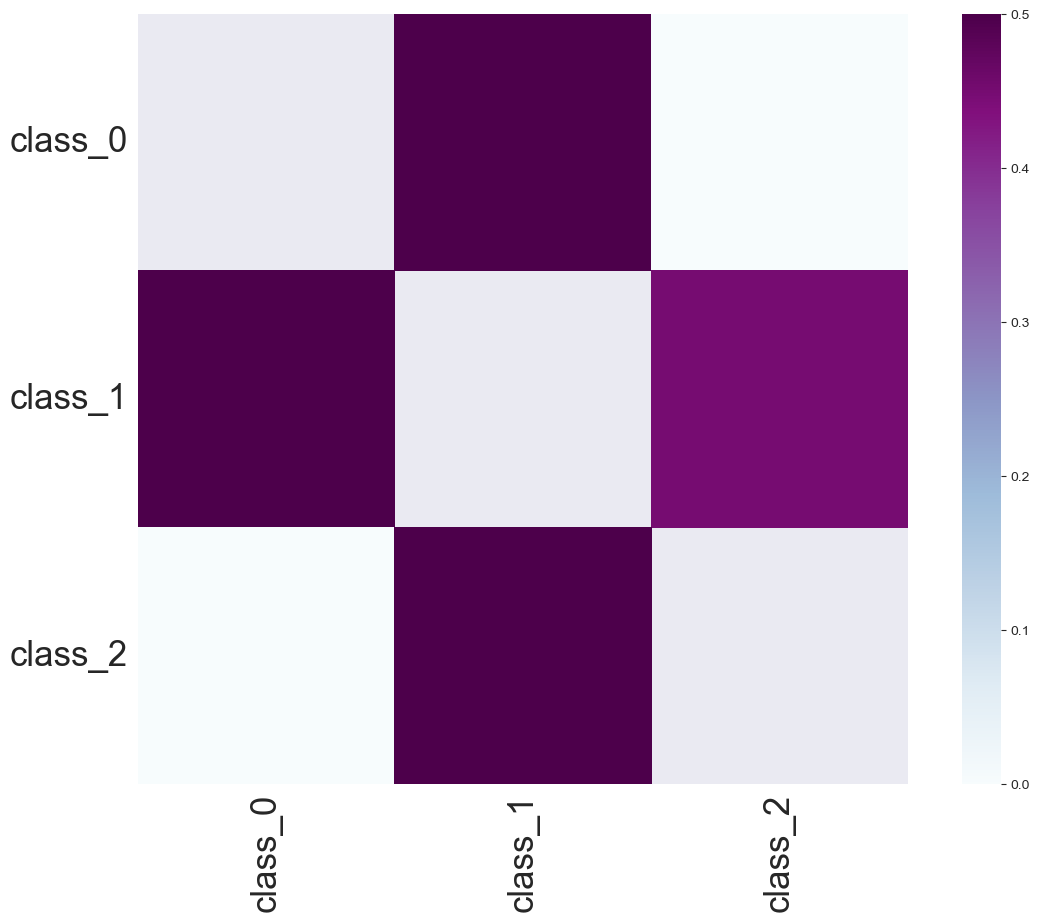

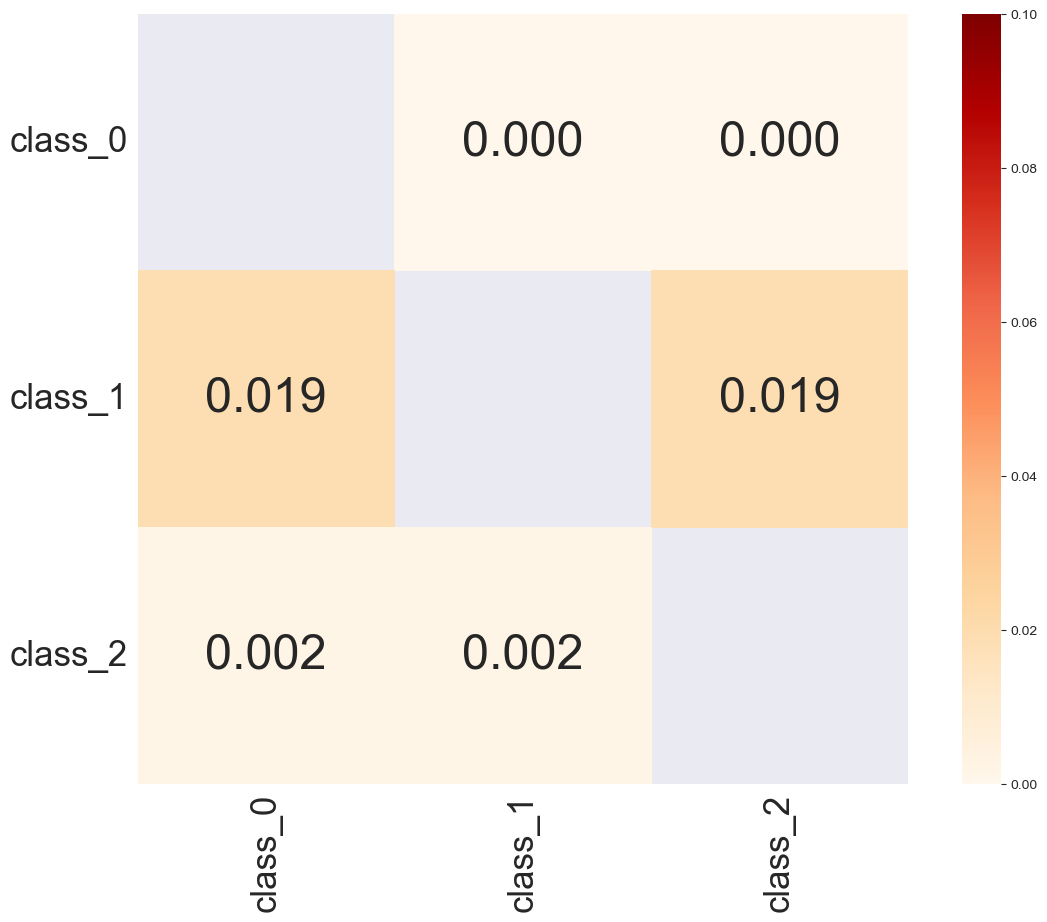

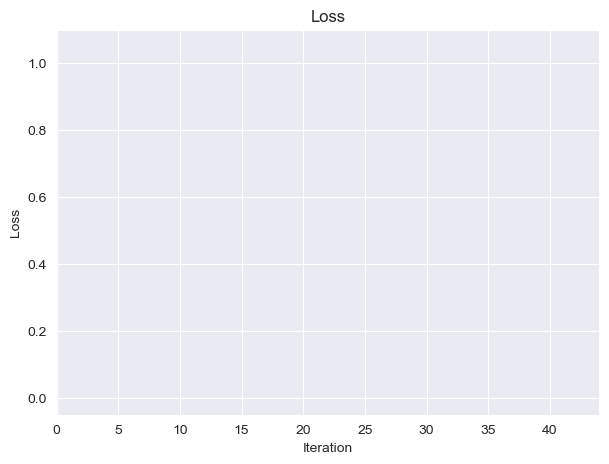

2021-09-11 22:23:58,560 - ClusterPlot-23869 - INFO - Starting iteration 2 loss = 0.5789473684210527
2021-09-11 22:23:58,594 - ClusterPlot-23869 - INFO - Starting iteration 3 loss = 0.4473684210526316
2021-09-11 22:23:58,628 - ClusterPlot-23869 - INFO - Starting iteration 4 loss = 0.4473684210526316
2021-09-11 22:23:58,661 - ClusterPlot-23869 - INFO - Starting iteration 5 loss = 0.3319838056680162
2021-09-11 22:23:58,695 - ClusterPlot-23869 - INFO - Starting iteration 6 loss = 0.2807017543859649
2021-09-11 22:23:58,729 - ClusterPlot-23869 - INFO - Starting iteration 7 loss = 0.30634278002699056
2021-09-11 22:23:58,763 - ClusterPlot-23869 - INFO - Starting iteration 8 loss = 0.2550607287449393
2021-09-11 22:23:58,797 - ClusterPlot-23869 - INFO - Starting iteration 9 loss = 0.2550607287449393
2021-09-11 22:23:58,832 - ClusterPlot-23869 - INFO - Starting iteration 10 loss = 0.2550607287449393
2021-09-11 22:23:58,866 - ClusterPlot-23869 - INFO - Starting iteration 11 loss = 0.30634278002699

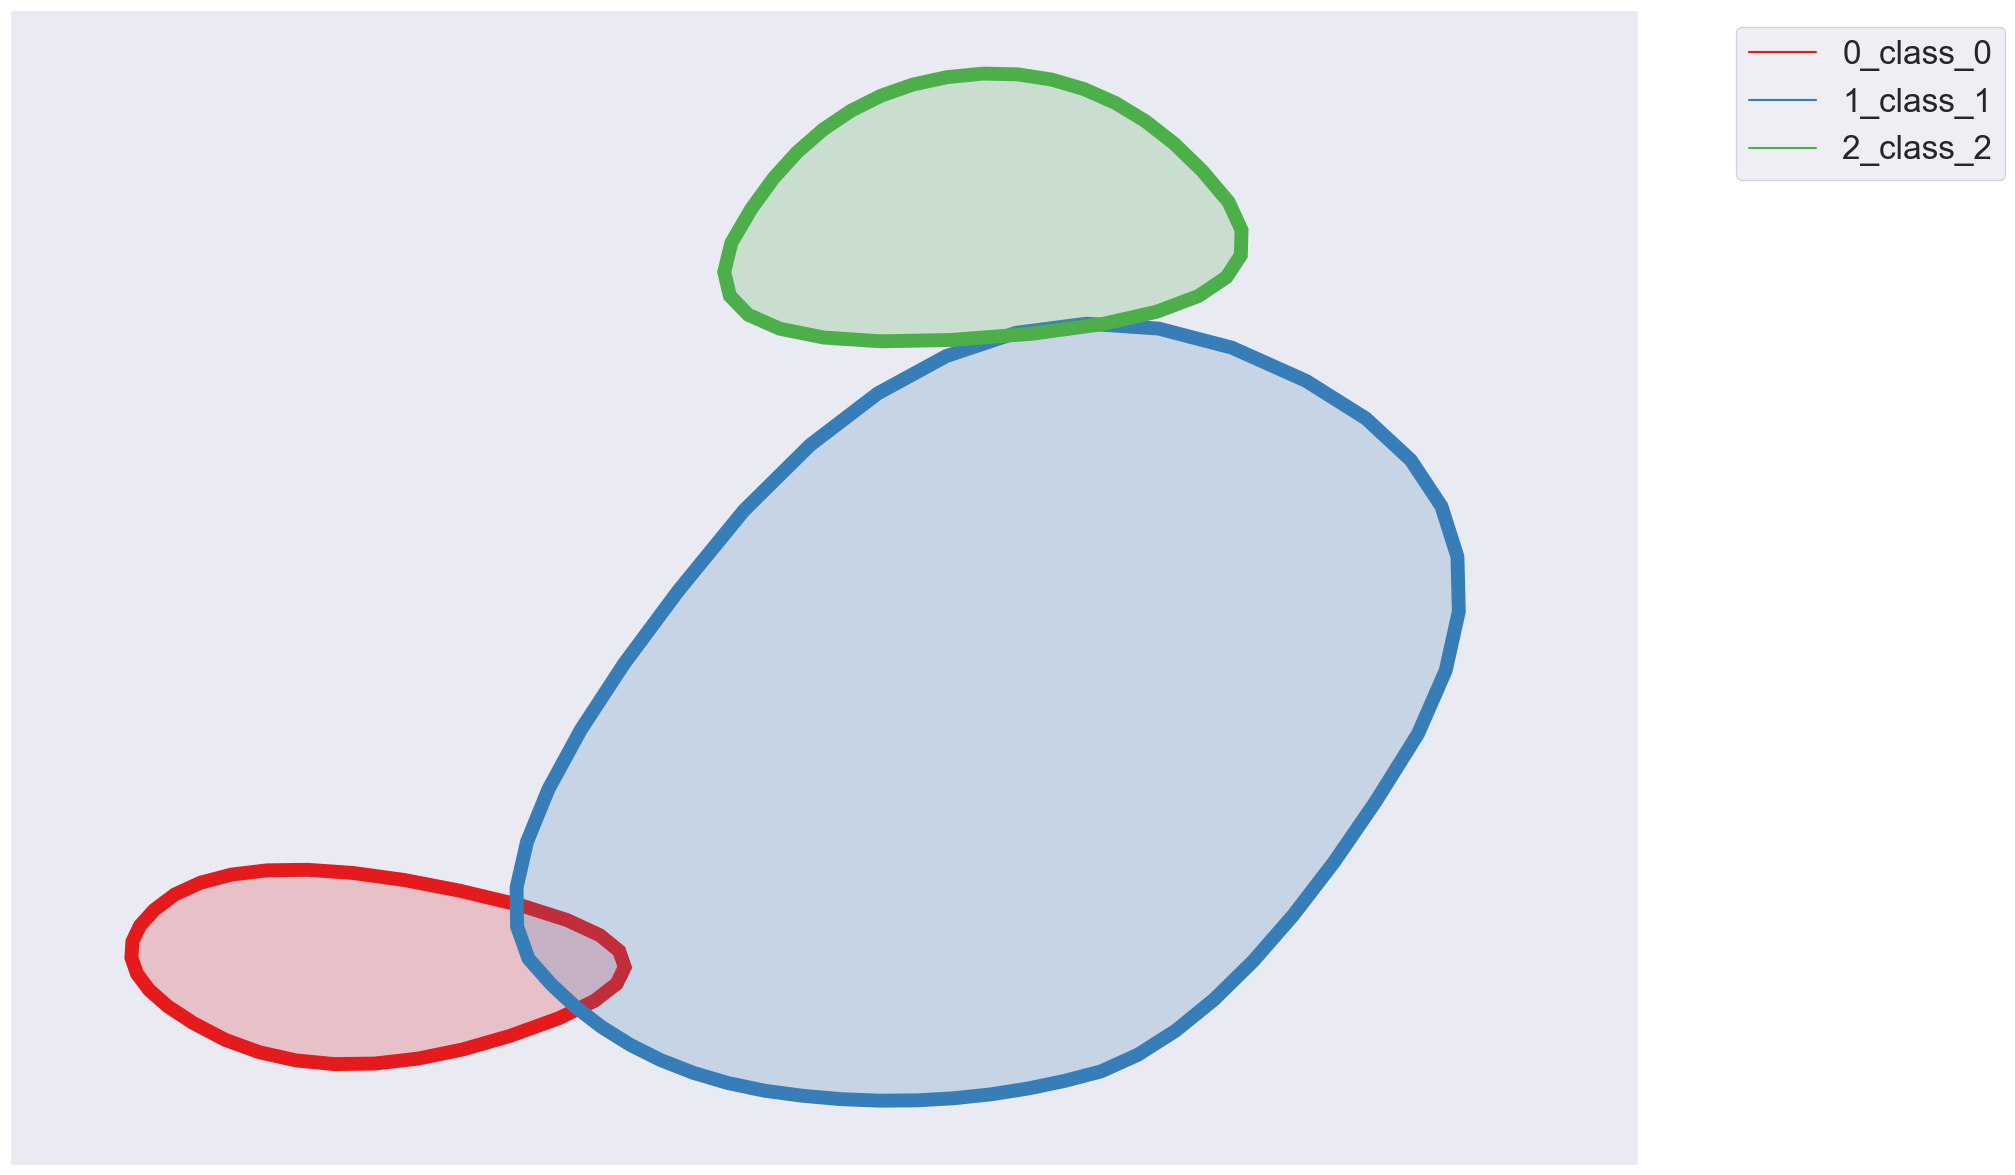

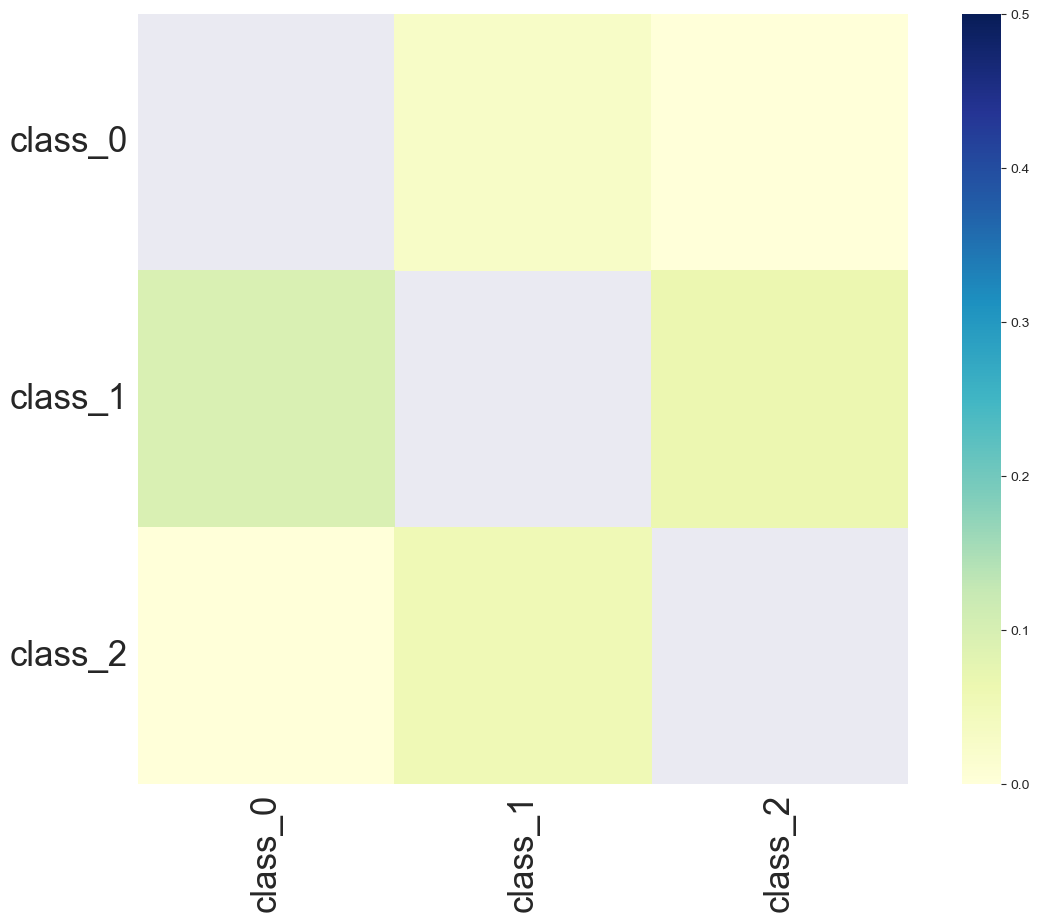

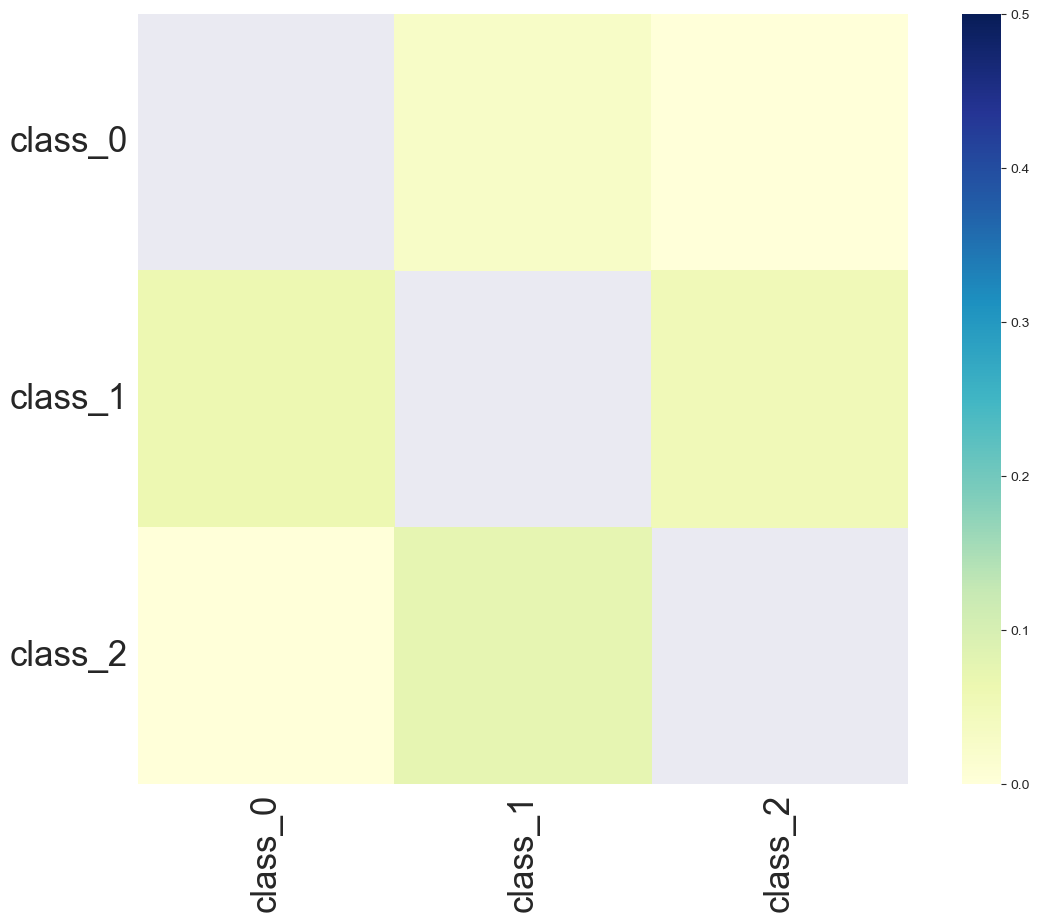

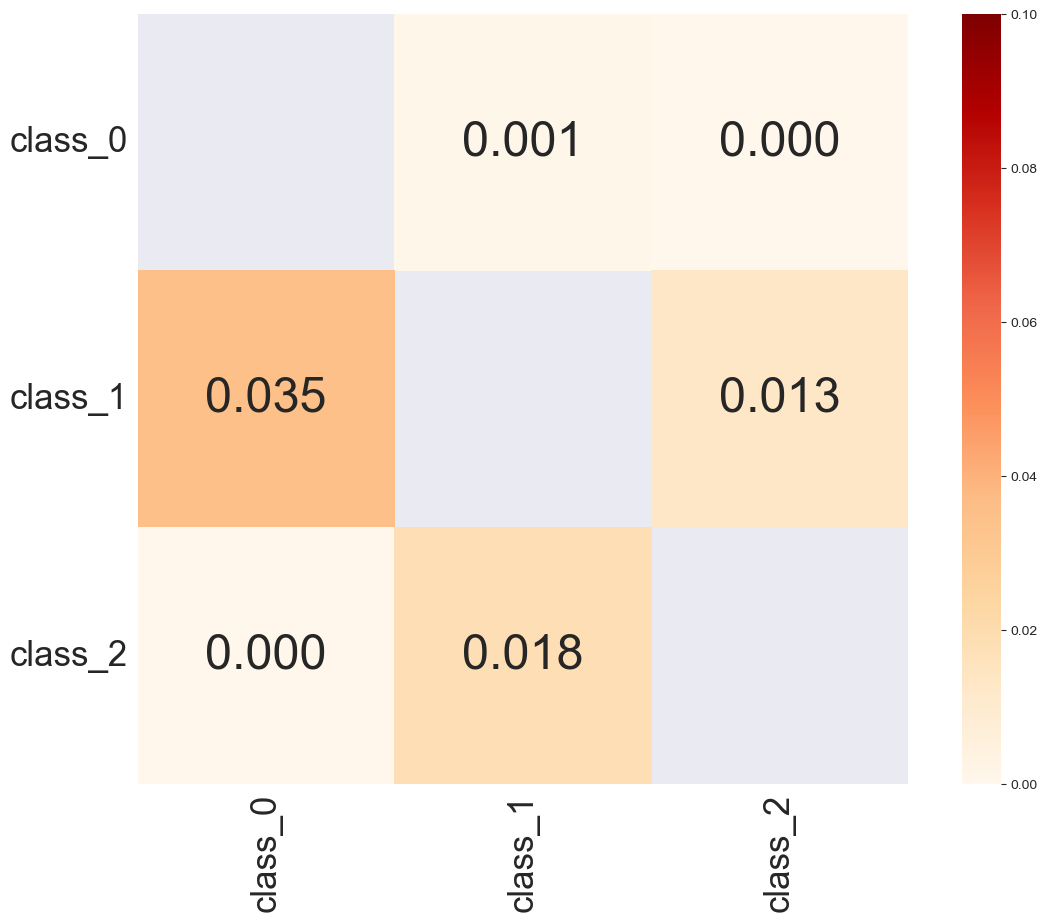

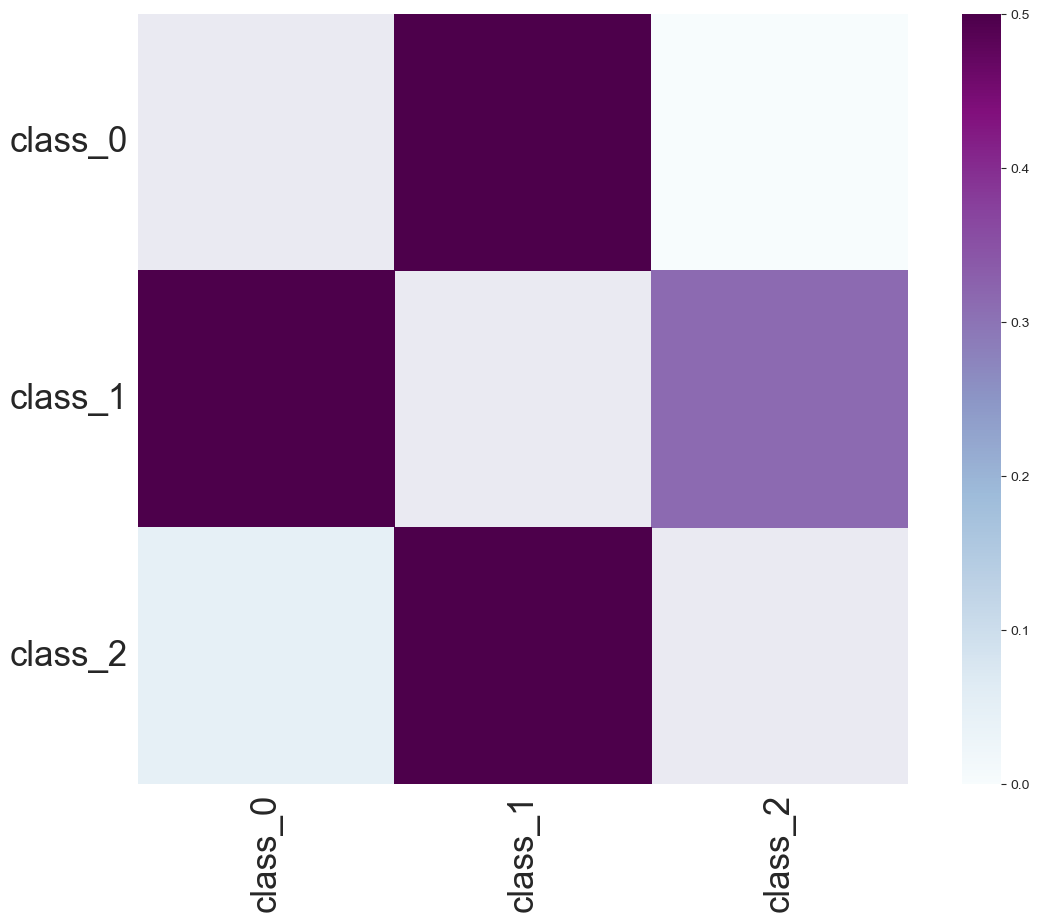

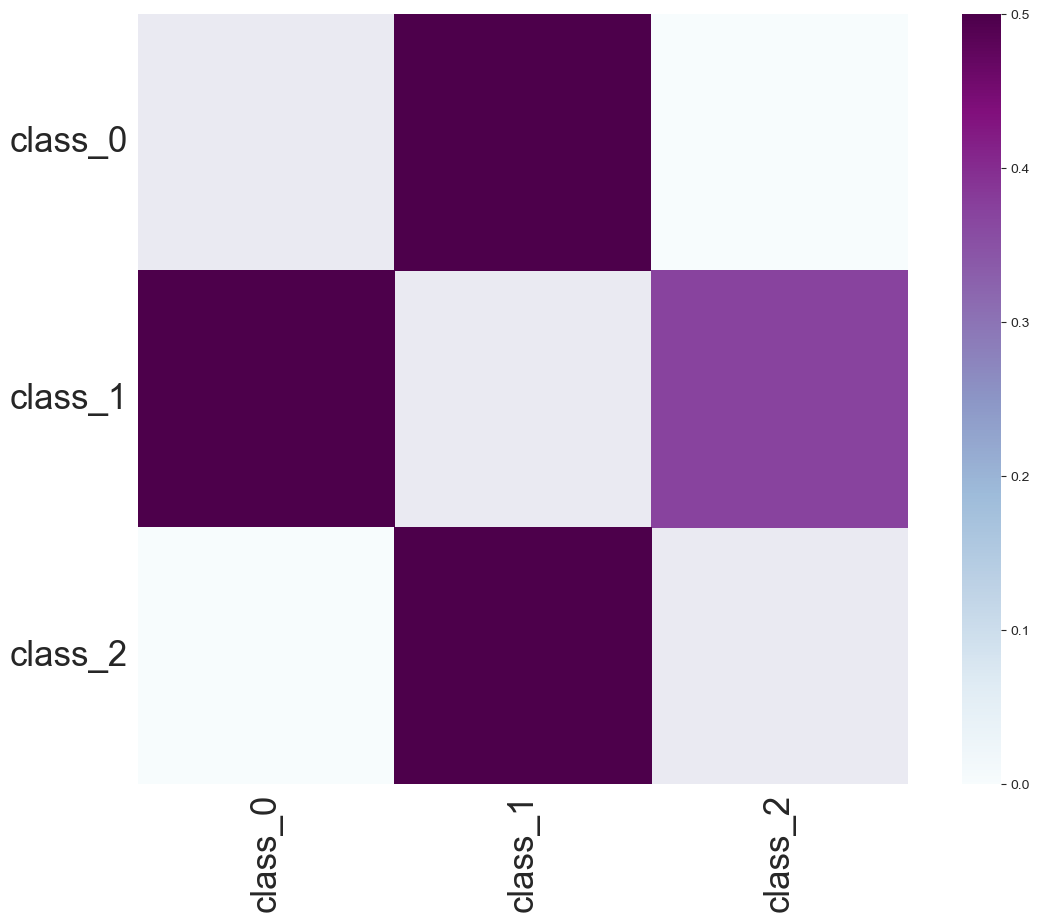

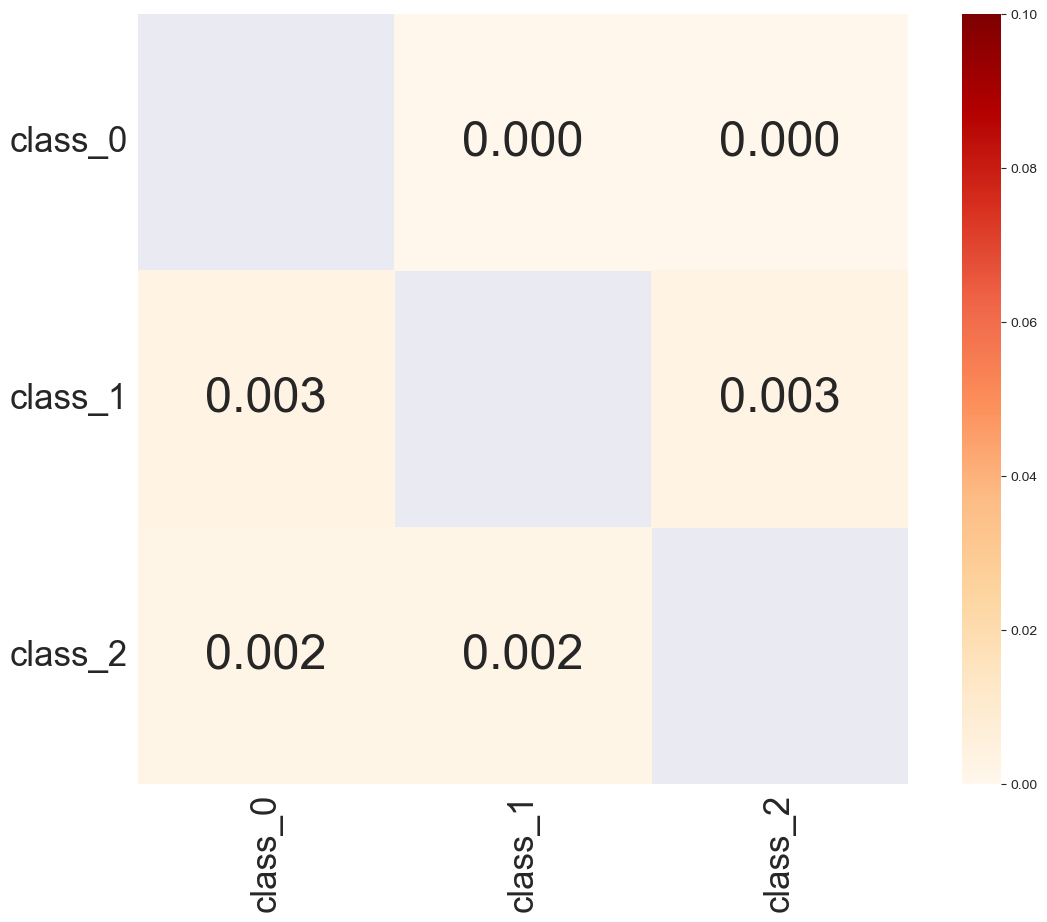

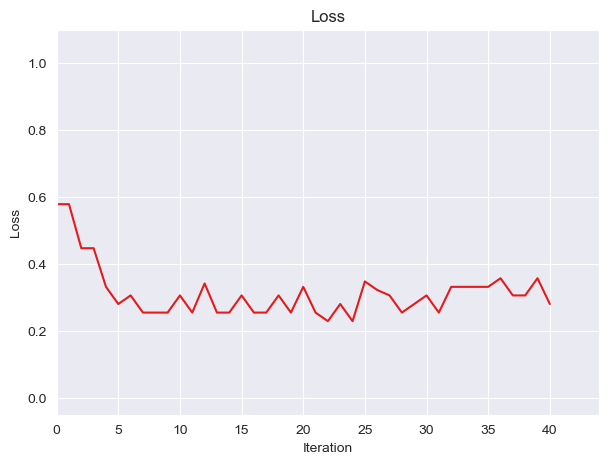

In [20]:
low_sim_blobs = blobs_cp.fit_transform(X_scaled, y_scaled)

In [21]:
pd.Series(y).value_counts().sort_index()

NameError: name 'y' is not defined

In [ ]:
blobs_cp.num_clusters_each_label, blobs_cp.num_clusters_each_label.sum()

In [ ]:
# config for red with three classes
# blobs_cp.alpha = [0.75,0.5,0.5]
blobs_cp.alpha = [0,0,0]
blobs_cp.show_anchors = True
blobs_cp.show_blobs = True
blobs_cp.douglas_peucker_tolerance=0.1
blobs_cp.anchors_plot_sns_separate(1, True)